In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import matplotlib.pyplot as plt
%matplotlib notebook

import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder

import datetime

from pandas.tseries.offsets import *

In [1350]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

In [140]:
import time
 def getNowTime():
    return time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))

In [3]:
train_path = './data/train'

In [2442]:
tag_df = pd.read_csv(os.path.join(train_path, 'train_tag.csv'), na_values= ['-1', '\\N'])

In [2443]:
tag_df.dtypes

id                                  object
flag                                 int64
gdr_cd                              object
age                                  int64
mrg_situ_cd                         object
edu_deg_cd                          object
acdm_deg_cd                         object
deg_cd                              object
job_year                           float64
ic_ind                             float64
fr_or_sh_ind                       float64
dnl_mbl_bnk_ind                    float64
dnl_bind_cmb_lif_ind               float64
hav_car_grp_ind                    float64
hav_hou_grp_ind                    float64
l6mon_agn_ind                      float64
frs_agn_dt_cnt                     float64
vld_rsk_ases_ind                   float64
fin_rsk_ases_grd_cd                float64
confirm_rsk_ases_lvl_typ_cd        float64
cust_inv_rsk_endu_lvl_cd           float64
l6mon_daim_aum_cd                  float64
tot_ast_lvl_cd                     float64
pot_ast_lvl

In [2444]:
tag_df= tag_df.set_index('id', drop= True)

#### 缺失值所占比例

In [2445]:
tag_df.isna().sum() / len(tag_df)

flag                               0.000000
gdr_cd                             0.018435
age                                0.000000
mrg_situ_cd                        0.018435
edu_deg_cd                         0.329935
acdm_deg_cd                        0.018461
deg_cd                             0.543521
job_year                           0.012349
ic_ind                             0.012349
fr_or_sh_ind                       0.012349
dnl_mbl_bnk_ind                    0.012349
dnl_bind_cmb_lif_ind               0.012349
hav_car_grp_ind                    0.012524
hav_hou_grp_ind                    0.012349
l6mon_agn_ind                      0.012524
frs_agn_dt_cnt                     0.779851
vld_rsk_ases_ind                   0.012524
fin_rsk_ases_grd_cd                0.785587
confirm_rsk_ases_lvl_typ_cd        0.701626
cust_inv_rsk_endu_lvl_cd           0.012524
l6mon_daim_aum_cd                  0.012524
tot_ast_lvl_cd                     0.774616
pot_ast_lvl_cd                  

两个属性的缺失比例大于70%， 分别是tot_ast_lvl_cd   fin_rsk_ases_grd_cd  frs_agn_dt_cnt    confirm_rsk_ases_lvl_typ_cd ，依据之前模型训练的经验，这几个属性都没有出现在top50特征中，这里将这几个属性丢掉

In [2446]:
tag_df= tag_df.drop(columns = ['tot_ast_lvl_cd', 'fin_rsk_ases_grd_cd', 'frs_agn_dt_cnt', 'confirm_rsk_ases_lvl_typ_cd'] )

对于数值特征中的许多分级特征，可以直接采用均值填充，最好检查一下分布，避免异常值的存在破坏均值分布, 检查了一下，数值类特征中没有发现异常值
对于类别特征，'gdr_cd', 'mrg_situ_cd', 'edu_deg_cd', 'acdm_deg_cd', 'deg_cd'，可以填充众数，或者-1，异常值，考虑到像婚姻状态这样的类别变量，还是填充-1靠谱一些

In [2447]:
label = tag_df['flag']
tag_df.drop(columns= 'flag', inplace= True)

<IPython.core.display.Javascript object>


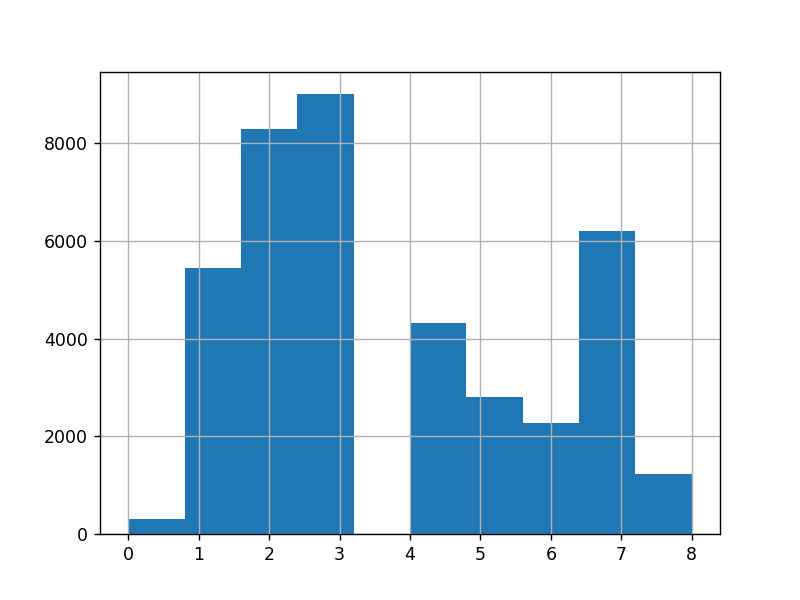

In [2448]:
tag_df['perm_crd_lmt_cd'].hist()

<IPython.core.display.Javascript object>


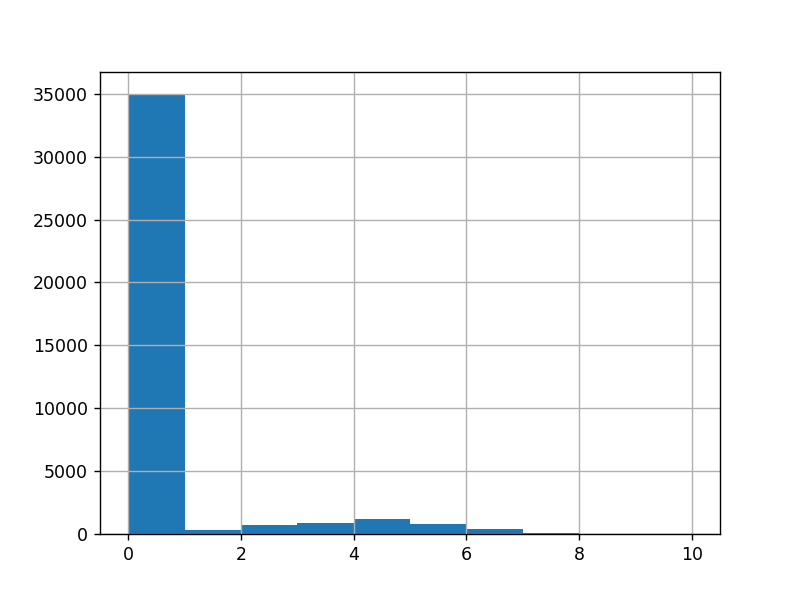

In [2449]:
tag_df['bk1_cur_year_mon_avg_agn_amt_cd'].hist()

检查每月发放工资金额属性，发现大量样本为0，也就是不再招行发放工资，但并不代表样本没有工资，可能在其他行，所以构造两个特征，是否在招行发放工资，并把0数值替换为除0外的平均值

In [2450]:
tag_df['wu_gongzi_zai_zhaoyin'] = tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] == 0

tag_df.loc[tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] == 0, 'bk1_cur_year_mon_avg_agn_amt_cd'] = np.mean(tag_df.loc[tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] != 0, 'bk1_cur_year_mon_avg_agn_amt_cd'])

In [2451]:
tag_num_df = tag_df.loc[:, tag_df.dtypes != np.dtype('O')].astype('float')

tag_ct_df = tag_df.loc[:, tag_df.dtypes == np.dtype('O')]

tag_ct_df.fillna('-1', inplace= True)

tag_num_df_f= tag_num_df.fillna(tag_num_df.mean())

/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [2464]:
ct_cols = tag_ct_df.columns
num_cols = tag_num_df.columns

In [2453]:
train_tag_df_f = pd.concat([tag_ct_df, tag_num_df_f], axis = 1)

因为是使用比例特征，所以必须考虑到缺失值，将缺失作为一类的话，应该使用填充缺失以后的数据

In [2454]:
tag_oh_ct_cols = [col for col in train_tag_df_f.columns if re.fullmatch('.+_cd', col) or re.fullmatch('.+_ind', col)]

def get_tag_ct_count_df(tag_df, tag_ct_ratio_dict):
    tag_ct_ratio_df = pd.DataFrame(index= tag_df.index)
    for col in tag_ct_ratio_dict:
        tag_ct_ratio_df['%s_ratio' %(col, )] = tag_df[col].map(tag_ct_ratio_dict[col])
    return tag_ct_ratio_df

tag_ct_ratio_dict = {}
for col in tag_oh_ct_cols:
    tag_ct_ratio_dict[col] = train_tag_df_f.groupby(col)[col].count() / train_tag_df_f.shape[0]

train_tag_ct_ratio_df = get_tag_ct_count_df(train_tag_df_f, tag_ct_ratio_dict)

In [2455]:
oh_encoder = OneHotEncoder()
tag_ct_oh = oh_encoder.fit_transform(tag_ct_df)
oh_encoder.categories_

oh_cat_columns = []
for i, ct_col in enumerate(ct_cols):
    for cat in oh_encoder.categories_[i]:
        oh_cat_columns.append('%s_%s' %(ct_col, cat))

oh_train_tag_arr_f= np.concatenate([tag_ct_oh.toarray(), tag_num_df_f.values], axis = 1)
train_tag_arr = np.concatenate([tag_ct_oh.toarray(), tag_num_df.values], axis = 1)

tag_num_cols = tag_num_df.columns
train_oh_tag_df = pd.DataFrame(train_tag_arr, index= tag_df.index, columns = oh_cat_columns + list(tag_num_cols))
# print(train_oh_tag_df.dtypes)
train_oh_tag_df_f = pd.DataFrame(oh_train_tag_arr_f, index= tag_df.index, columns = oh_cat_columns + list(tag_num_cols))

train_usr_index = train_oh_tag_df.index

train_oh_tag_df = pd.concat([train_oh_tag_df, train_tag_ct_ratio_df], axis = 1)


train_oh_tag_df_f = pd.concat([train_oh_tag_df_f, train_tag_ct_ratio_df], axis = 1)






检查了一下，对了潜力资产分类，指数是个很好的分布

In [2456]:
def add_div_feat(tag_df):
    tag_df['over_30d_loan_div_credit_min_opn_dt'] = tag_df['ovd_30d_loan_tot_cnt'] / tag_df['cur_credit_min_opn_dt_cnt']

    tag_df['l1y_crd_card_csm_div_pot_ast_lvl_cd'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / np.exp(tag_df['pot_ast_lvl_cd'])

    tag_df['bk1_cur_year_mon_avg_div_l1y_crd_card_csm'] = tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] / np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd'])
    
    tag_df['l1y_crd_card_csm_div_perm_crd_lmt_cd']= np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / (tag_df['perm_crd_lmt_cd'] + 1)
    
    tag_df['l1y_crd_card_csm_div_pl_crd_lmt_cd'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / (tag_df['pl_crd_lmt_cd'] + 1)
    
    tag_df['cur_credit_cnt_div_credit_min_opn_dt_cnt'] = tag_df['cur_credit_cnt'] / tag_df['cur_credit_min_opn_dt_cnt']
    
    tag_df['cur_debit_cnt_div_cur_debit_min_opn_dt_cnt'] = tag_df['cur_debit_cnt'] / tag_df['cur_debit_min_opn_dt_cnt']
    
    tag_df['l1y_crd_card_csm_amt_dlm_cd_div_hld_crd_card_grd_cd'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / (tag_df['hld_crd_card_grd_cd'] + 1)
    
    tag_df['l1y_crd_card_csm_amt_dlm_cd_div_debit_card_grd_cd'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / (tag_df['cur_debit_crd_lvl'] + 1)

#     tag_df['l1y_crd_card_csm_amt_dlm_cd_div_cur_credit_min_opn_yr_cnt'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) / tag_df['cur_credit_min_opn_dt_cnt'] * 360
                                                                                 
#     tag_df['l1y_crd_card_csm_amt_dlm_cd_mul_cur_credit_min_opn_yr_cnt'] = np.exp(tag_df['l1y_crd_card_csm_amt_dlm_cd']) * tag_df['cur_credit_min_opn_dt_cnt'] / 360
    
    return tag_df

In [2457]:
train_oh_tag_df = add_div_feat(train_oh_tag_df)
train_oh_tag_df_f = add_div_feat(train_oh_tag_df_f)

In [2458]:
missing_count_sr = tag_df.isna().sum(axis= 1)

train_oh_tag_df['missing_count'] = missing_count_sr
train_oh_tag_df_f['missing_count'] = missing_count_sr

检查测试集

In [2459]:
test_path = './data/testb'

In [2460]:
test_tag_df = pd.read_csv(os.path.join(test_path, 'test_tag.csv'), na_values= ['-1', '\\N'])

test_tag_df= test_tag_df.set_index('id', drop= True)

In [2461]:
test_tag_df= test_tag_df.drop(columns = ['tot_ast_lvl_cd', 'fin_rsk_ases_grd_cd', 'frs_agn_dt_cnt', 'confirm_rsk_ases_lvl_typ_cd'] )

In [2462]:
test_tag_df.head()

,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
id,,,,,,,,,,,,,,,,,,,,,
U1E63A3,M,40,B,C,31,NaN,1.0,0.0,1.0,0.0,...,25.0,1.0,5.0,0.0,7,1,1,4047.0,4260.0,10
U3EC77F,M,46,A,C,31,NaN,3.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,4,2,1,5460.0,3317.0,10
U27DC0C,M,42,B,F,G,NaN,3.0,0.0,0.0,1.0,...,10.0,1.0,5.0,1.0,7,3,2,4103.0,4108.0,10
U3FAAAC,F,35,B,B,30,NaN,5.0,0.0,1.0,1.0,...,20.0,0.0,0.0,0.0,3,3,1,4733.0,4748.0,20
U04EA0B,M,34,A,F,G,NaN,9.0,0.0,0.0,1.0,...,10.0,1.0,3.0,1.0,7,6,2,4525.0,1670.0,20


In [2463]:
test_tag_df['wu_gongzi_zai_zhaoyin'] = test_tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] == 0

test_tag_df.loc[test_tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] == 0, 'bk1_cur_year_mon_avg_agn_amt_cd'] = np.mean(test_tag_df.loc[test_tag_df['bk1_cur_year_mon_avg_agn_amt_cd'] != 0, 'bk1_cur_year_mon_avg_agn_amt_cd'])

In [2465]:
test_tag_ct_df = test_tag_df[ct_cols]

test_tag_ct_df.fillna('-1', inplace= True)
test_tag_num_df = test_tag_df[num_cols].astype('float')

test_tag_num_df_f= test_tag_num_df.fillna(tag_num_df.mean())

/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [2466]:
test_tag_df_f = pd.concat([test_tag_ct_df, test_tag_num_df_f], axis = 1)

test_tag_ct_ratio_df = get_tag_ct_count_df(test_tag_df_f, tag_ct_ratio_dict)


# test_tag_ct_arr = ct_encoder.transform(test_tag_ct_df)
test_tag_ct_oh = oh_encoder.transform(test_tag_ct_df)
test_tag_arr = np.concatenate([test_tag_ct_oh.toarray(), test_tag_num_df.values], axis= 1)

new_test_tag_df = pd.DataFrame(test_tag_arr, index = test_tag_df.index, columns = oh_cat_columns + list(num_cols))
test_oh_tag_df = new_test_tag_df


test_tag_arr_f= np.concatenate([test_tag_ct_oh.toarray(), test_tag_num_df_f.values], axis = 1)

test_oh_tag_df_f = pd.DataFrame(test_tag_arr_f, index= test_tag_df.index, columns = oh_cat_columns + list(num_cols))

test_oh_tag_df = pd.concat([test_oh_tag_df, test_tag_ct_ratio_df], axis = 1)


test_oh_tag_df_f = pd.concat([test_oh_tag_df_f, test_tag_ct_ratio_df], axis = 1)



In [2467]:
test_oh_tag_df = add_div_feat(test_oh_tag_df)
test_oh_tag_df_f = add_div_feat(test_oh_tag_df_f)

In [2468]:
test_missing_count_sr = test_tag_df.isna().sum(axis= 1)

test_oh_tag_df['missing_count'] = test_missing_count_sr
test_oh_tag_df_f['missing_count'] = test_missing_count_sr

In [2231]:
# np.save(os.path.join(test_path, 'test_tag_arr.npy'), test_tag_arr)

In [2469]:
test_usr_index = new_test_tag_df.index

查看训练和测试集用户集合的差别

In [2470]:
train_users = set(tag_df.index)

test_users = set(test_tag_df.index)

len(train_users & test_users)

0

训练和测试用户集合没有交集，所以用户id看起来就没有用处了

检查正例/反例比例

In [2471]:
np.sum(label)/label.shape[0]

0.22425669413621221

正例比例约为20%,存在失衡，但不严重

#### 增加没有历史交易指示特征

In [2481]:
train_trd_df = pd.read_csv(os.path.join(train_path, 'train_trd.csv'), parse_dates= ['trx_tm'] )

train_trd_df = train_trd_df.loc[np.logical_or(train_trd_df['cny_trx_amt'] > 0.2, train_trd_df['cny_trx_amt'] < -0.2)]

In [2482]:
def find_no_trd_users(data, trd_df, offset, suffix):
    data['no_trd_%s' %suffix] = np.zeros(len(data))
    trd_users = set(trd_df.loc[trd_df['trx_tm'] > last - offset, 'id'].unique())
    all_users = set(data.index)
    no_trd_users = all_users - trd_users
    print(len(no_trd_users))
    data.loc[no_trd_users, 'no_trd_%s' %suffix] = 1
    return no_trd_users

In [2483]:
def find_no_beh_users(data, beh_df, offset, suffix):
    data['no_beh_%s' %suffix] = np.zeros(len(data))
    beh_users = set(beh_df.loc[beh_df['page_tm'] > last - offset, 'id'].unique())
    all_users = set(data.index)

    no_beh_users = all_users - beh_users
    print(len(no_beh_users))
    data.loc[no_beh_users, 'no_beh_%s' %suffix] = 1
    return no_beh_users

In [2484]:
t = find_no_trd_users(train_oh_tag_df, train_trd_df, DateOffset(months = 2), 'last2month')
t = find_no_trd_users(train_oh_tag_df, train_trd_df, DateOffset(months = 1), 'last1month')
t = find_no_trd_users(train_oh_tag_df, train_trd_df, DateOffset(weeks = 2), 'last2week')

t = find_no_trd_users(train_oh_tag_df, train_trd_df, DateOffset(weeks = 1), 'last1week')

t = find_no_trd_users(train_oh_tag_df_f, train_trd_df, DateOffset(months = 2), 'last2month')
t = find_no_trd_users(train_oh_tag_df_f, train_trd_df, DateOffset(months = 1), 'last1month')
t = find_no_trd_users(train_oh_tag_df_f, train_trd_df, DateOffset(weeks = 2), 'last2week')

t = find_no_trd_users(train_oh_tag_df_f, train_trd_df, DateOffset(weeks = 1), 'last1week')



8846
11024
15036
20898
8846
11024
15036
20898


In [2485]:
print(label[train_oh_tag_df_f['no_trd_last2week'] == 1].mean(), label[train_oh_tag_df_f['no_trd_last2month'] == 1].mean(), label[train_oh_tag_df_f['no_trd_last1month'] == 1].mean())

0.3073290768821495 0.2613610671489939 0.2896407837445573


In [2486]:
t = find_no_trd_users(test_oh_tag_df, test_trd_df, DateOffset(months = 2), 'last2month')
t = find_no_trd_users(test_oh_tag_df, test_trd_df, DateOffset(months = 1), 'last1month')
t = find_no_trd_users(test_oh_tag_df, test_trd_df, DateOffset(weeks = 2), 'last2week')

t = find_no_trd_users(test_oh_tag_df, test_trd_df, DateOffset(weeks = 1), 'last1week')

t = find_no_trd_users(test_oh_tag_df_f, test_trd_df, DateOffset(months = 2), 'last2month')
t = find_no_trd_users(test_oh_tag_df_f, test_trd_df, DateOffset(months = 1), 'last1month')
t = find_no_trd_users(test_oh_tag_df_f, test_trd_df, DateOffset(weeks = 2), 'last2week')

t = find_no_trd_users(test_oh_tag_df_f, test_trd_df, DateOffset(weeks = 1), 'last1week')

814
995
1306
2052
814
995
1306
2052


####  没有历史APP行为的指示特征

In [2487]:
t = find_no_beh_users(train_oh_tag_df, train_beh_df, DateOffset(months = 1), 'last1month')
t = find_no_beh_users(train_oh_tag_df, train_beh_df, DateOffset(weeks = 2), 'last2week')

t = find_no_beh_users(train_oh_tag_df, train_beh_df, DateOffset(weeks = 1), 'last1week')

t = find_no_beh_users(train_oh_tag_df_f, train_beh_df, DateOffset(months = 1), 'last1month')
t = find_no_beh_users(train_oh_tag_df_f, train_beh_df, DateOffset(weeks = 2), 'last2week')

t = find_no_beh_users(train_oh_tag_df_f, train_beh_df, DateOffset(weeks = 1), 'last1week')

28010
29848
31849
28010
29848
31849


In [2488]:
t = find_no_beh_users(test_oh_tag_df, test_beh_df, DateOffset(months = 1), 'last1month')
t = find_no_beh_users(test_oh_tag_df, test_beh_df, DateOffset(weeks = 2), 'last2week')

t = find_no_beh_users(test_oh_tag_df, test_beh_df, DateOffset(weeks = 1), 'last1week')

t = find_no_beh_users(test_oh_tag_df_f, test_beh_df, DateOffset(months = 1), 'last1month')
t = find_no_beh_users(test_oh_tag_df_f, test_beh_df, DateOffset(weeks = 2), 'last2week')

t = find_no_beh_users(test_oh_tag_df_f, test_beh_df, DateOffset(weeks = 1), 'last1week')

2768
2954
3143
2768
2954
3143


#### 过去两个月内完全没有交易行为的用户 26% 违约了，比正常比例偏高

#### 过去两周没有行为的用户则有30% 违约了，过去一个月29 %

## 使用历史交易数据

In [2480]:
last = pd.Timestamp(datetime.datetime(2019, 7, 1))

last1week = last - Week(1)

last2week = last - Week(2)

last1month = last - MonthEnd()

begin = pd.Timestamp(datetime.datetime(2019, 6, 1))

In [2489]:
cat_cols = ['Dat_Flg1_Cd', 'Dat_Flg3_Cd', 'Trx_Cod1_Cd', 'Trx_Cod2_Cd']

encoder = OneHotEncoder(handle_unknown = 'ignore')
data = encoder.fit_transform(train_trd_df[cat_cols])

In [2491]:
feat_name_ls = []
for i, col in enumerate(cat_cols):
    for cat in encoder.categories_[i]:
        feat_name_ls.append('%s_%s' %(col, cat))

In [2492]:
train_trd_cat_arr = data.toarray()

train_trd_oh_df = pd.DataFrame(train_trd_cat_arr, index = train_trd_df.index, columns = feat_name_ls)

new_train_trd_df = pd.concat([train_trd_oh_df, train_trd_df[['trx_tm', 'id', 'cny_trx_amt']]], axis = 1)

In [2377]:
# new_train_trd_df.to_csv(os.path.join(train_path, 'train_trd_oh.csv'))

In [2493]:
def history_statistic(trd_df, offset, num_weeks, suffix, user_index):
    begin = last - offset

    cat_agg = trd_df.loc[trd_df['trx_tm'] > begin].groupby('id')[feat_name_ls].agg(['sum', 'mean'])

    num_agg = trd_df.loc[trd_df['trx_tm'] > begin].groupby('id')['cny_trx_amt'].agg(['sum', 'mean', 'std', 'max', 'min', 'count'])

    num_agg['max_min_ratio'] = num_agg['max'] / num_agg['min']
    
    cat_agg.columns = ['_'.join(t) for t in cat_agg.columns]

    feats = pd.concat([cat_agg, num_agg], axis = 1)

    if num_weeks > 1:
        sum_feat_names = [name for name in feats.columns if name.find('sum') != -1 ]

        feats_per_week = feats[sum_feat_names] / num_weeks

        feats_per_week.rename(columns = lambda s: s + '_perweek', inplace= True)

        feats = pd.concat([feats, feats_per_week], axis = 1)

    feats.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    feats_f = feats.reindex(user_index)
    feats_f.fillna(0, inplace= True)
    return feats, feats_f

In [2494]:
st_feat_last1week, st_feat_last1week_f  = history_statistic(new_train_trd_df, Week(1), 1, 'last1week', train_usr_index)

st_feat_last2week, st_feat_last2week_f = history_statistic(new_train_trd_df, Week(2), 2, 'last2week', train_usr_index)

st_feat_last1month, st_feat_last1month_f = history_statistic(new_train_trd_df, DateOffset(months = 1), 4, 'last1month', train_usr_index)

st_feat_last2month, st_feat_last2month_f = history_statistic(new_train_trd_df, DateOffset(months = 2), 8, 'last2month', train_usr_index)

train_user_hist_df = pd.concat([st_feat_last1week, st_feat_last2week, st_feat_last1month, st_feat_last2month], axis = 1)

train_user_hist_df_f = pd.concat([st_feat_last1week_f, st_feat_last2week_f, st_feat_last1month_f, st_feat_last2month_f], axis = 1)

#### 增加历史交易额统计与支出与信用卡持卡等级，最近一年信用卡消费分层，信用卡永久额度分层，信用卡张数，借记卡张数，借记卡持卡等级， 个贷额度分级，月均代发金额分层的比例，可以理解为个人消费能力和还款能力的历史统计特征, 这些特征可以使用包含缺失值版本，也需要使用进行缺失值填充后的版本

In [2523]:
train_oh_tag_df['perm_crd_lmt_cd'].describe()

count    39916.000000
mean         3.691001
std          2.123807
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          8.000000
Name: perm_crd_lmt_cd, dtype: float64

In [2617]:


psn_feats = train_oh_tag_df[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd', 'bk1_cur_year_mon_avg_agn_amt_cd']]
psn_feats_f = train_oh_tag_df_f[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd', 'bk1_cur_year_mon_avg_agn_amt_cd']]

# 为了避免除0错误，得到无效特征，对于信用卡/借记卡级别特征加1处理
psn_feats.loc[:, ['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] = psn_feats[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] + 1
psn_feats_f.loc[:, ['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] = psn_feats_f[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] + 1

psn_feats['l1y_crd_card_csm_amt_dlm_cd_exp'] = np.exp(psn_feats['l1y_crd_card_csm_amt_dlm_cd'])
psn_feats_f['l1y_crd_card_csm_amt_dlm_cd_exp'] = np.exp(psn_feats_f['l1y_crd_card_csm_amt_dlm_cd'])

/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

由于存在分层特征数值为0的情况，不适合做除法，数值+1,考虑现实世界中的消费能力分布，做指数计算

In [2499]:
def get_hist_out_div_feats(trd_df, offset, suffix, num_weeks, psn_feats, psn_feats_f):
    begin = last - offset

    hist_out = trd_df[np.logical_and(trd_df['trx_tm'] > begin, trd_df['cny_trx_amt'] < 0)].groupby('id')['cny_trx_amt'].sum()
    if num_weeks > 1:

        hist_out_perweek = hist_out / num_weeks
    else:
        hist_out_perweek = hist_out



    hist_out_pw = hist_out_perweek.reindex(psn_feats.index)
    hist_out_pw = hist_out_pw.fillna(0)

    div_arr = hist_out_pw.values.reshape(-1, 1) / psn_feats.values

    div_df = pd.DataFrame(div_arr, index = psn_feats.index, columns = ['out_pw_div_' + col for col in psn_feats.columns])



    div_arr_f = hist_out_pw.values.reshape(-1, 1) / psn_feats_f.values
    div_df_f = pd.DataFrame(div_arr_f, index = psn_feats.index, columns = ['out_pw_div_' + col for col in psn_feats.columns])

    div_df.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    div_df_f.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    return div_df, div_df_f

In [2500]:
def get_hist_in_div_feats(trd_df, offset, suffix, num_weeks, psn_feats, psn_feats_f):
    begin = last - offset

    hist_out = trd_df[np.logical_and(trd_df['trx_tm'] > begin, trd_df['cny_trx_amt'] > 0)].groupby('id')['cny_trx_amt'].sum()
    if num_weeks > 1:

        hist_out_perweek = hist_out / num_weeks
    else:
        hist_out_perweek = hist_out



    hist_out_pw = hist_out_perweek.reindex(psn_feats.index)
    hist_out_pw = hist_out_pw.fillna(0)

    div_arr = hist_out_pw.values.reshape(-1, 1) / psn_feats.values

    div_df = pd.DataFrame(div_arr, index = psn_feats.index, columns = ['in_pw_div_' + col for col in psn_feats.columns])



    div_arr_f = hist_out_pw.values.reshape(-1, 1) / psn_feats_f.values
    div_df_f = pd.DataFrame(div_arr_f, index = psn_feats.index, columns = ['in_pw_div_' + col for col in psn_feats.columns])

    div_df.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    div_df_f.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    return div_df, div_df_f

In [2501]:
def get_hist_sum_div_feats(trd_df, offset, suffix, num_weeks, psn_feats, psn_feats_f):
    begin = last - offset

    hist_out = trd_df[trd_df['trx_tm'] > begin].groupby('id')['cny_trx_amt'].sum()
    if num_weeks > 1:

        hist_out_perweek = hist_out / num_weeks
    else:
        hist_out_perweek = hist_out



    hist_out_pw = hist_out_perweek.reindex(psn_feats.index)
    hist_out_pw = hist_out_pw.fillna(0)

    div_arr = hist_out_pw.values.reshape(-1, 1) / psn_feats.values

    div_df = pd.DataFrame(div_arr, index = psn_feats.index, columns = ['sum_pw_div_' + col for col in psn_feats.columns])



    div_arr_f = hist_out_pw.values.reshape(-1, 1) / psn_feats_f.values
    div_df_f = pd.DataFrame(div_arr_f, index = psn_feats.index, columns = ['sum_pw_div_' + col for col in psn_feats.columns])

    div_df.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    div_df_f.rename(columns = lambda s: s + '_' + suffix, inplace= True)
    return div_df, div_df_f

In [2619]:
out_div_l2w_df, out_div_l2w_df_f = get_hist_out_div_feats(new_train_trd_df, Week(2), 'last2week', 2, psn_feats, psn_feats_f)

out_div_l1w_df, out_div_l1w_df_f = get_hist_out_div_feats(new_train_trd_df, Week(1), 'last1week', 1, psn_feats, psn_feats_f)

out_div_l1m_df, out_div_l1m_df_f = get_hist_out_div_feats(new_train_trd_df, DateOffset(months = 1), 'last1month', 4, psn_feats, psn_feats_f)

out_div_l2m_df, out_div_l2m_df_f = get_hist_out_div_feats(new_train_trd_df, DateOffset(months = 2), 'last2month', 8, psn_feats, psn_feats_f)

out_div_df = pd.concat([out_div_l2w_df, out_div_l1w_df, out_div_l1m_df, out_div_l2m_df], axis= 1)

out_div_df_f = pd.concat([out_div_l2w_df_f, out_div_l1w_df_f, out_div_l1m_df_f, out_div_l2m_df_f], axis= 1)

in_div_l2w_df, in_div_l2w_df_f = get_hist_in_div_feats(new_train_trd_df, Week(2), 'last2week', 2, psn_feats, psn_feats_f)

in_div_l1w_df, in_div_l1w_df_f = get_hist_in_div_feats(new_train_trd_df, Week(1), 'last1week', 1, psn_feats, psn_feats_f)

in_div_l1m_df, in_div_l1m_df_f = get_hist_in_div_feats(new_train_trd_df, DateOffset(months = 1), 'last1month', 4, psn_feats, psn_feats_f)

in_div_l2m_df, in_div_l2m_df_f = get_hist_in_div_feats(new_train_trd_df, DateOffset(months = 2), 'last2month', 8, psn_feats, psn_feats_f)

in_div_df = pd.concat([in_div_l2w_df, in_div_l1w_df, in_div_l1m_df, in_div_l2m_df], axis= 1)

in_div_df_f = pd.concat([in_div_l2w_df_f, in_div_l1w_df_f, in_div_l1m_df_f, in_div_l2m_df_f], axis= 1)

sum_div_l2w_df, sum_div_l2w_df_f = get_hist_sum_div_feats(new_train_trd_df, Week(2), 'last2week', 2, psn_feats, psn_feats_f)

sum_div_l1w_df, sum_div_l1w_df_f = get_hist_sum_div_feats(new_train_trd_df, Week(1), 'last1week', 1, psn_feats, psn_feats_f)

sum_div_l1m_df, sum_div_l1m_df_f = get_hist_sum_div_feats(new_train_trd_df, DateOffset(months = 1), 'last1month', 4, psn_feats, psn_feats_f)

sum_div_l2m_df, sum_div_l2m_df_f = get_hist_sum_div_feats(new_train_trd_df, DateOffset(months = 2), 'last2month', 8, psn_feats, psn_feats_f)

sum_div_df = pd.concat([sum_div_l2w_df, sum_div_l1w_df, sum_div_l1m_df, sum_div_l2m_df], axis= 1)

sum_div_df_f = pd.concat([sum_div_l2w_df_f, sum_div_l1w_df_f, sum_div_l1m_df_f, sum_div_l2m_df_f], axis= 1)

hist_stat_div_df = pd.concat([out_div_df, in_div_df, sum_div_df], axis = 1)
hist_stat_div_df_f = pd.concat([out_div_df_f, in_div_df_f, sum_div_df_f], axis = 1)

In [2621]:
hist_stat_div_df.shape

(39923, 84)

这里有问题，存在nan，暂时不影响lightGBM训练，延后处理

#### 细分交易类别，统计交易总量

In [2527]:
cat_amt_feat_names = [feat_name + '_amt' for feat_name in feat_name_ls]

In [2528]:
train_trd_cat_amt_df= pd.DataFrame(new_train_trd_df[feat_name_ls].values * new_train_trd_df[['cny_trx_amt', ]].values, columns = cat_amt_feat_names, index = new_train_trd_df.index) 


train_trd_cat_amt_df = pd.concat([train_trd_cat_amt_df, new_train_trd_df[['id', 'trx_tm', 'cny_trx_amt']]], axis= 1)

In [2529]:
def get_trd_cat_stat(trd_cat_amt_df, offset, suffix, user_index): 

    trd_cat_sum_df = trd_cat_amt_df[trd_cat_amt_df['trx_tm'] > last - offset].groupby('id')[cat_amt_feat_names].sum()

    trd_cat_sum_df['total_sum'] = trd_cat_amt_df[trd_cat_amt_df['trx_tm'] > last - offset].groupby('id')['cny_trx_amt'].sum()

    for feat in cat_amt_feat_names:
        trd_cat_sum_df[feat + '_ratio'] = trd_cat_sum_df[feat] / (trd_cat_sum_df['total_sum'] + 1.7717)

    trd_cat_sum_df.rename(columns = lambda s: s + '_' + suffix, inplace = True)
    
    trd_cat_sum_df_f= trd_cat_sum_df.reindex(user_index)
    trd_cat_sum_df_f.fillna(0, inplace= True)
    return trd_cat_sum_df, trd_cat_sum_df_f

In [2530]:
train_trd_cat_stat_l1w, train_trd_cat_stat_l1w_f  = get_trd_cat_stat(train_trd_cat_amt_df, Week(1), 'last1week', train_usr_index)

train_trd_cat_stat_l2w, train_trd_cat_stat_l2w_f = get_trd_cat_stat(train_trd_cat_amt_df, Week(2), 'last2week', train_usr_index)

train_trd_cat_stat_l1m, train_trd_cat_stat_l1m_f = get_trd_cat_stat(train_trd_cat_amt_df, DateOffset(months = 1), 'last1month', train_usr_index)

train_trd_cat_stat_l2m, train_trd_cat_stat_l2m_f = get_trd_cat_stat(train_trd_cat_amt_df, DateOffset(months = 2),'last2month', train_usr_index)

train_trd_cat_stat_df = pd.concat([train_trd_cat_stat_l1w, train_trd_cat_stat_l2w, train_trd_cat_stat_l1m, train_trd_cat_stat_l2m], axis = 1)
train_trd_cat_stat_df_f = pd.concat([train_trd_cat_stat_l1w_f, train_trd_cat_stat_l2w_f, train_trd_cat_stat_l1m_f, train_trd_cat_stat_l2m_f], axis = 1)

#### 可以统计支付方式和交易一级分类的分窗统计，以及分窗的变化

In [2531]:
sub_amt_feat_names = ['Dat_Flg3_Cd_A_amt', 'Dat_Flg3_Cd_B_amt', 'Dat_Flg3_Cd_C_amt', 'Trx_Cod1_Cd_1_amt', 'Trx_Cod1_Cd_2_amt',
 'Trx_Cod1_Cd_3_amt',]

In [2533]:
def get_trd_sub_stat_df(trd_df, week_ls, period_str, agg_func, user_index):
    num_periods = len(week_ls) - 1
    stat_df_ls = []
    for i in range(num_periods):
        begin_date = week_ls[i]
        end_date = week_ls[i + 1]
        srs = trd_df[np.logical_and(trd_df['trx_tm'] >= begin_date, trd_df['trx_tm'] < end_date)].groupby('id')[sub_amt_feat_names].agg(agg_func)
        srs.rename(columns = lambda s : s + '_' + period_str + '_' + str(i) + '_' + agg_func, inplace= True)
        srs= srs.reindex(user_index)
        srs.fillna(0, inplace= True)
        stat_df_ls.append(srs)
        
    stat_array = np.stack(stat_df_ls)
    trd_mean_cols = [col+ '_%s_mean' %(period_str, ) for col in sub_amt_feat_names]
    trd_mean_arr = np.mean(stat_array, axis= 0)
    trd_mean_df = pd.DataFrame(trd_mean_arr, index = user_index, columns = trd_mean_cols)
#     print(trd_mean_df.head())
    trd_std_cols = [col+ '_%s_std' %(period_str, ) for col in sub_amt_feat_names]
    trd_std_arr = np.std(stat_array, axis= 0)
    trd_std_df = pd.DataFrame(trd_std_arr, index = user_index, columns = trd_std_cols)
    
    trd_cv_cols = [col+ '_%s_cv' %(period_str, ) for col in sub_amt_feat_names]
    trd_cv_arr = trd_std_arr / (trd_mean_arr + 1.717E-5)
    trd_cv_df = pd.DataFrame(trd_cv_arr, index = user_index, columns = trd_cv_cols)
    
    trd_range_cols = [col+ '_%s_range' %(period_str, ) for col in sub_amt_feat_names]
    trd_range_arr = np.max(stat_array, axis = 0) - np.min(stat_array, axis = 0)
    trd_range_df = pd.DataFrame(trd_range_arr, index = user_index, columns = trd_range_cols)
    
    diff_ratio_df_ls = []
    for i in range(1, num_periods):
        diff_ratio = (stat_df_ls[i].values - stat_df_ls[i - 1].values) / (stat_df_ls[i - 1].values + 1.717171)
        diff_ratio_df = pd.DataFrame(diff_ratio, index= user_index, columns = [col + '_diff_ratio' for col in stat_df_ls[i].columns])
    #     print(diff_ratio_df.head())
        diff_ratio_df_ls.append(diff_ratio_df)

    trd_sub_stat_df = pd.concat([*stat_df_ls, trd_mean_df, trd_std_df, trd_cv_df, *diff_ratio_df_ls], axis = 1)

    if num_periods > 2:
        diff_ratio_array = np.stack(diff_ratio_df_ls)
        diff_ratio_mean_cols = [col+ '_%s_diff_ratio_mean' %(period_str, ) for col in sub_amt_feat_names]
        diff_ratio_mean = np.mean(diff_ratio_array, axis = 0)
        diff_ratio_mean_df = pd.DataFrame(diff_ratio_mean, index = user_index, columns = diff_ratio_mean_cols)

        diff_ratio_median_cols = [col+ '_%s_diff_ratio_median' %(period_str, ) for col in sub_amt_feat_names]
        diff_ratio_median = np.median(diff_ratio_array, axis = 0)
        diff_ratio_median_df = pd.DataFrame(diff_ratio_median, index = user_index, columns = diff_ratio_median_cols)

        diff_ratio_std_cols = [col+ '_%s_diff_ratio_std' %(period_str, ) for col in sub_amt_feat_names]
        diff_ratio_std = np.std(diff_ratio_array, axis = 0)
        diff_ratio_std_df = pd.DataFrame(diff_ratio_std, index = user_index, columns = diff_ratio_std_cols)

        diff_ratio_cv_cols = [col+ '_%s_diff_ratio_cv' %(period_str, ) for col in sub_amt_feat_names]
        diff_ratio_cv = diff_ratio_std / (diff_ratio_mean + 1.17171E-7)
        diff_ratio_cv_df = pd.DataFrame(diff_ratio_cv, index = user_index, columns = diff_ratio_cv_cols)

        diff_ratio_stat_df= pd.concat([diff_ratio_mean_df, diff_ratio_median_df, diff_ratio_std_df, diff_ratio_cv_df], axis= 1)
        trd_sub_stat_df = pd.concat([trd_sub_stat_df, diff_ratio_stat_df], axis = 1)
        
    return trd_sub_stat_df, trd_sub_stat_df

In [2534]:
trd_sub_week_stat_df, trd_sub_week_stat_df_f = get_trd_sub_stat_df(train_trd_cat_amt_df, week_ls, 'week', 'sum', train_usr_index)

trd_sub_month_stat_df, trd_sub_month_stat_df_f = get_trd_sub_stat_df(train_trd_cat_amt_df, month_ls, 'month', 'sum', train_usr_index)

trd_sub_biweek_stat_df, trd_sub_biweek_stat_df_f = get_trd_sub_stat_df(train_trd_cat_amt_df, biweek_ls, 'biweek', 'sum', train_usr_index)

trd_sub_wd_stat_df = pd.concat([trd_sub_week_stat_df, trd_sub_month_stat_df, trd_sub_biweek_stat_df], axis= 1)
trd_sub_wd_stat_df_f = pd.concat([trd_sub_week_stat_df_f, trd_sub_month_stat_df_f, trd_sub_biweek_stat_df_f], axis= 1)

#### 统计最后几次交易的统计量

In [2535]:
new_train_trd_df['trd_rank'] = new_train_trd_df.groupby('id')['trx_tm'].rank(ascending= False)

In [2536]:
def get_trd_lk_stat(trd_df, k, usr_index):
    trd_stat_lk= trd_df[trd_df['trd_rank'] <= k].groupby('id')['cny_trx_amt'].agg(['sum', 'std', 'mean'])
    trd_stat_lk.rename(columns = lambda s: 'trd_stat_l%d_' %(k, ) + s, inplace= True)
    trd_stat_lk_f= trd_stat_lk.reindex(usr_index)
    trd_stat_lk_f.fillna(0, inplace= True)

    return trd_stat_lk, trd_stat_lk_f

In [2537]:
trd_stat_l5, trd_stat_l5_f = get_trd_lk_stat(new_train_trd_df, 5, train_usr_index)
trd_stat_l15, trd_stat_l15_f = get_trd_lk_stat(new_train_trd_df, 15, train_usr_index)
trd_stat_l30, trd_stat_l30_f = get_trd_lk_stat(new_train_trd_df, 30, train_usr_index)
trd_stat_l100, trd_stat_l100_f = get_trd_lk_stat(new_train_trd_df, 100, train_usr_index)

In [2538]:
train_trd_stat_lk = pd.concat([trd_stat_l5, trd_stat_l15, trd_stat_l30, trd_stat_l100], axis= 1)
train_trd_stat_lk_f = pd.concat([trd_stat_l5_f, trd_stat_l15_f, trd_stat_l30_f, trd_stat_l100_f], axis= 1)

In [2539]:
train_trd_stat_lk.shape, train_trd_stat_lk_f.shape

((31099, 12), (39923, 12))

由于75%的人在过去两个月只有十次一下的交易行为，所以统计大量的交易行为并没有意义，统计最近5次到10次的收支就好

#### 交易分周的统计特征

In [2548]:
def get_trd_window_stat_0(trd_df, date_ls, agg_func, user_index):
    num_periods = len(date_ls) - 1
    df = pd.DataFrame(index= user_index)
    for i in range(num_periods):
        begin_date = date_ls[i]
        end_date = date_ls[i + 1]
        
        srs = trd_df.loc[np.logical_and(trd_df['trx_tm'] >= begin_date, trd_df['trx_tm'] < end_date)].groupby('id')['cny_trx_amt'].agg(agg_func)

        df['trd_%s_week%d_sum' %(agg_func, i + 1)] = srs
        
    df.fillna(0, inplace= True)
    
    arr = df.values
        
    df['week_std'] = np.std(arr, axis = 1)
    df['week_mean'] = np.mean(arr, axis = 1)
    df['week_cv'] = df['week_std'] / (df['week_mean'] + 0.17777)
    df['increse_weeks'] = np.sum(arr > 0, axis = 1)
    df['decrease_weeks'] = np.sum(arr < 0, axis = 1)
    df['decrease_minus_increase_weeks'] = df['decrease_weeks'] -  df['increse_weeks'] 
    df['no_act_weeks'] = np.sum(arr == 0, axis = 1)

    df['week_range'] = np.max(arr, axis= 1) - np.min(arr, axis= 1)

    df['week_range_ratio'] = np.max(arr, axis= 1) / (np.min(arr, axis= 1) + 0.1777)
    return df, df

In [2549]:
begin = last - DateOffset(months = 2)

num_periods = 8

date_ls= pd.date_range(begin, last, num_periods + 1)

In [2550]:
train_trd_wd_sum, train_trd_wd_sum_f = get_trd_window_stat_0(train_trd_df, date_ls, 'sum', train_usr_index)

#### 考虑到大部分人的收支特征应该是按月进行的，进行按月收支统计，也可以按周进行收支统计

In [2551]:
def get_trd_window_stat_1(trd_df, date_ls, agg_func, period_str, user_index, periods= None):    
    num_periods = len(date_ls) - 1
    df = pd.DataFrame(index= user_index)
    for i in range(num_periods):
        begin_date = date_ls[i]
        end_date = date_ls[i + 1]
        
        srs_out = trd_df[np.logical_and(np.logical_and(trd_df['trx_tm'] >= begin_date, trd_df['trx_tm'] < end_date),trd_df['Dat_Flg1_Cd'] == 'B')].groupby('id')['cny_trx_amt'].agg(agg_func)
        srs_in = trd_df[np.logical_and(np.logical_and(trd_df['trx_tm'] >= begin_date, trd_df['trx_tm'] < end_date),trd_df['Dat_Flg1_Cd'] == 'C')].groupby('id')['cny_trx_amt'].agg(agg_func)
        df['trd_%s%d_%s_in' %(period_str, i + 1, agg_func)] = srs_in
        df['trd_%s%d_%s_in' %(period_str, i + 1, agg_func)].fillna(0, inplace= True)
        if i > 0:
            df['trd_%s%d_%s_in_diff_ratio' %(period_str, i + 1, agg_func)] = df['trd_%s%d_%s_in' %(period_str, i + 1, agg_func)] / (df['trd_%s%d_%s_in' %(period_str, i, agg_func)] + 0.1777)
#             print(periods)
            if periods != None and i >= periods :
                df['trd_%s%d_%s_in_lastmonth_diff_ratio' %(period_str, i + 1, agg_func)] = df['trd_%s%d_%s_in' %(period_str, i + 1, agg_func)] / (df['trd_%s%d_%s_in' %(period_str, i - periods + 1, agg_func)] + 0.1777)
        df['trd_%s%d_%s_out' %(period_str, i + 1, agg_func)] = srs_out
        df['trd_%s%d_%s_out' %(period_str, i + 1, agg_func)].fillna(0, inplace= True)
        df['trd_%s%d_%s_outin_ratio' %(period_str, i + 1, agg_func)] =  df['trd_%s%d_%s_out' %(period_str, i + 1, agg_func)] / (df['trd_%s%d_%s_in' %(period_str, i + 1, agg_func)] + 0.17777)
        if i > 0:
            df['trd_%s%d_%s_out_diff_ratio' %(period_str, i + 1, agg_func)] = df['trd_%s%d_%s_out' %(period_str, i + 1, agg_func)] / (df['trd_%s%d_%s_out' %(period_str, i, agg_func)] + 0.17777)
            if periods != None and i >= periods:
                df['trd_%s%d_%s_out_lastmonth_diff_ratio' %(period_str, i + 1, agg_func)] = df['trd_%s%d_%s_out' %(period_str, i + 1, agg_func)] / (df['trd_%s%d_%s_out' %(period_str, i - periods + 1, agg_func)] + 0.1)
    in_cols = [col for col in df.columns if re.fullmatch( 'trd_.+_in', col,)]
    out_cols = [col for col in df.columns if re.fullmatch('trd_.+_out', col, )]
#     print(in_cols, out_cols)
    df['trd_out_%s_std' %(period_str)] = np.std(df[out_cols], axis = 1)
    df['trd_out_%s_mean'  %(period_str)] = np.mean(df[out_cols], axis = 1)
    df['trd_out_%s_cv'  %(period_str)] = df['trd_out_%s_std' %(period_str)] / (df['trd_out_%s_mean' %(period_str)] + 0.1777)
    
    df['trd_in_%s_std'  %(period_str)] = np.std(df[in_cols], axis = 1)
    df['trd_in_%s_mean'  %(period_str)] = np.mean(df[in_cols], axis = 1)
    df['trd_in_%s_cv'  %(period_str)] = df['trd_in_%s_std' %(period_str)] / (df['trd_in_%s_mean' %(period_str)] + 0.1777)

    df['trd_%s_mean_outin_ratio' %(period_str)] = df['trd_out_%s_mean'  %(period_str)] /  (df['trd_in_%s_mean'  %(period_str)] + 1)
    
    outin_ratio_cols = [col for col in df.columns if re.fullmatch( 'trd_.+_outin_ratio', col,)]
    df['trd_%s_outin_ratio_mean' %(period_str)] = np.mean(df[outin_ratio_cols], axis = 1)
    df['trd_%s_outin_ratio_max' %(period_str)] = np.max(df[outin_ratio_cols], axis = 1)
    df['trd_%s_outin_ratio_min' %(period_str)] = np.min(df[outin_ratio_cols], axis = 1)
    df['trd_%s_outin_ratio_std' %(period_str)] = np.std(df[outin_ratio_cols], axis = 1)
    df['trd_%s_outin_ratio_cv' %(period_str)] =df['trd_%s_outin_ratio_std' %(period_str)] / (df['trd_%s_outin_ratio_mean' %(period_str)]  + 1.7777)
    
    if num_periods > 2:
        out_diff_ratio_cols = ['trd_%s%d_%s_out_diff_ratio' %(period_str, i + 1, agg_func) for i in range(1, num_periods)]
        df['trd_%s_%s_out_diff_ratio_mean' %(period_str, agg_func)] = np.mean(df[out_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_out_diff_ratio_max' %(period_str, agg_func)] = np.max(df[out_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_out_diff_ratio_min' %(period_str, agg_func)] = np.min(df[out_diff_ratio_cols], axis = 1)
        
        in_diff_ratio_cols = ['trd_%s%d_%s_in_diff_ratio' %(period_str, i + 1, agg_func) for i in range(1, num_periods)]
        df['trd_%s_%s_in_diff_ratio_mean' %(period_str, agg_func)] = np.mean(df[in_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_in_diff_ratio_max' %(period_str, agg_func)] = np.max(df[in_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_in_diff_ratio_min' %(period_str, agg_func)] = np.min(df[in_diff_ratio_cols], axis = 1)
        
    if periods != None and num_periods > periods:
        out_lastmonth_diff_ratio_cols = ['trd_%s%d_%s_out_lastmonth_diff_ratio' %(period_str, i + 1, agg_func) for i in range(periods, num_periods)]
#         print(out_lastmonth_diff_ratio_cols)
        df['trd_%s_%s_out_lastmonth_diff_ratio_mean' %(period_str, agg_func)] = np.mean(df[out_lastmonth_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_out_lastmonth_diff_ratio_max' %(period_str, agg_func)] = np.max(df[out_lastmonth_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_out_lastmonth_diff_ratio_min' %(period_str, agg_func)] = np.min(df[out_lastmonth_diff_ratio_cols], axis = 1)
        
        in_lastmonth_diff_ratio_cols = ['trd_%s%d_%s_in_lastmonth_diff_ratio' %(period_str, i + 1, agg_func) for i in range(periods, num_periods)]
#         print(in_lastmonth_diff_ratio_cols)
        df['trd_%s_%s_in_lastmonth_diff_ratio_mean' %(period_str, agg_func)] = np.mean(df[in_lastmonth_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_in_lastmonth_diff_ratio_max' %(period_str, agg_func)] = np.max(df[in_lastmonth_diff_ratio_cols], axis = 1)
        df['trd_%s_%s_in_lastmonth_diff_ratio_min' %(period_str, agg_func)] = np.min(df[in_lastmonth_diff_ratio_cols], axis = 1)
        
    df_f = df.fillna(0)
    return df, df_f

 如何引入变化趋势特征，要区分正向变化，还是负向变化
 引入周期收入，支出统计，收入/支出比，收入支出的均值，方差，变异系数，支收比的均值，方差，最大，最小以及变异系数，收入的变化率或者支出的变化率，以及变化率的最大/最小等统计特征
 2020/05/03 增加按周，双周的上月同期收入，支出变化率特征

In [2552]:
month_ls= pd.date_range(begin, freq= DateOffset(months = 1), periods = 3)

month_ls

train_trd_month_inout_df, train_trd_month_inout_df_f = get_trd_window_stat_1(train_trd_df, month_ls, 'sum', 'month', train_usr_index)

biweek_ls = pd.date_range(begin, last, periods = 5)

biweek_ls

train_trd_biweek_inout_df, train_trd_biweek_inout_df_f = get_trd_window_stat_1(train_trd_df, biweek_ls, 'sum', 'biweek', train_usr_index, 2)

week_ls = pd.date_range(begin, last, periods = 9)

train_trd_week_inout_df, train_trd_week_inout_df_f = get_trd_window_stat_1(train_trd_df, week_ls, 'sum', 'week',train_usr_index, 4)

In [2554]:
train_trd_week_inout_df.shape

(39923, 70)

#### 过去时间窗口的交易时间统计

In [2555]:
new_train_trd_df['tm_slot'] = new_train_trd_df['trx_tm'].dt.hour // 3

new_train_trd_df['is_weekend'] = new_train_trd_df['trx_tm'].dt.weekday >= 5

In [2556]:
def get_trd_tm_slot_stat(trd_df, offset, suffix):
    tm_slot_df = trd_df[trd_df['trx_tm'] > last - offset].groupby('id')['tm_slot'].agg(['mean', 'std'])

    tm_slot_df.rename(columns = lambda s: 'trd_tm_slot_' + s + '_' + suffix, inplace= True)
    
    weekend_df = trd_df[trd_df['trx_tm'] > last - offset].groupby('id')['is_weekend'].agg(['mean', 'sum'])
    
    weekend_df = trd_df[trd_df['trx_tm'] > last - offset].groupby('id')['is_weekend'].agg(['mean', 'sum'])

    weekend_df.rename(columns = lambda s: 'weekend_trd_' + s + '_' + suffix, inplace = True)
    
    ret_df = pd.concat([tm_slot_df, weekend_df], axis= 1)
    
    
    return ret_df

In [2557]:
trd_tm_slot_last2month = get_trd_tm_slot_stat(new_train_trd_df, DateOffset(months = 2), 'last2month')

trd_tm_slot_last1month = get_trd_tm_slot_stat(new_train_trd_df, DateOffset(months = 1), 'last1month')

trd_tm_slot_last2week = get_trd_tm_slot_stat(new_train_trd_df, DateOffset(weeks = 2), 'last2week')

trd_tm_slot_last1week = get_trd_tm_slot_stat(new_train_trd_df, DateOffset(weeks = 1), 'last1week')

trd_tm_slot_stat0 = pd.concat([trd_tm_slot_last2month, trd_tm_slot_last1month, trd_tm_slot_last2week, trd_tm_slot_last1week], axis= 1)

#### 注意这里的填充-1没有实际意义

In [2558]:
trd_tm_slot_l2m_f = trd_tm_slot_last2month.reindex(train_usr_index).fillna(-1)
trd_tm_slot_l1m_f = trd_tm_slot_last1month.reindex(train_usr_index).fillna(-1)
trd_tm_slot_l2w_f = trd_tm_slot_last2week.reindex(train_usr_index).fillna(-1)
trd_tm_slot_l1w_f = trd_tm_slot_last1week.reindex(train_usr_index).fillna(-1)

trd_tm_slot_stat0_f =  pd.concat([trd_tm_slot_l2m_f, trd_tm_slot_l1m_f, trd_tm_slot_l2w_f, trd_tm_slot_l1w_f], axis= 1)

In [2559]:
coarse_feat_names = []
for i, col in enumerate(cat_cols):
    if i > 2:
        break;
    for cat in encoder.categories_[i]:
        coarse_feat_names.append('%s_%s' %(col, cat))

In [2560]:
def get_trd_tm_slot_sub_stat(trd_df, offset, suffix, user_index):
    tm_slot_sub_count= trd_df[trd_df['trx_tm'] > last - offset][coarse_feat_names + ['id', 'tm_slot', 'is_weekend']].groupby(['id', 'tm_slot']).agg(['sum', 'mean']).unstack()

    tm_slot_sub_count.fillna(0, inplace= True)

    tm_slot_sub_count.columns =[ str(col[0]) + '_' + str(col[1]) + '_tm_slot_' + str(col[2]) + '_' + suffix  for col in tm_slot_sub_count.columns]


    tm_slot_stat =  trd_df.loc[trd_df['trx_tm'] > last - offset].groupby(['id', 'tm_slot'])['trx_tm'].count().unstack()

    tm_slot_stat.fillna(0, inplace= True)

    tm_slot_stat_ratio = tm_slot_stat / np.sum(tm_slot_stat.values, axis = 1, keepdims= True)

    tm_slot_stat_ratio.rename(columns= lambda s: 'tm_slot_' + str(s) + '_ratio_' + suffix, inplace= True)

    
    tm_slot_stat.rename(columns= lambda s: 'tm_slot_' + str(s) + '_count_' + suffix, inplace= True)

    tm_slot_stat_df = pd.concat([tm_slot_stat, tm_slot_stat_ratio, tm_slot_sub_count], axis = 1)
    
    tm_slot_stat_df_f = tm_slot_stat_df.reindex(user_index)
    
    tm_slot_stat_df_f.fillna(0, inplace= True)
    
    return tm_slot_stat_df, tm_slot_stat_df_f

In [2561]:
trd_tm_slot_sub_l2m, trd_tm_slot_sub_l2m_f = get_trd_tm_slot_sub_stat(new_train_trd_df, DateOffset(months = 2), 'last2month', train_usr_index)

trd_tm_slot_sub_l1m, trd_tm_slot_sub_l1m_f = get_trd_tm_slot_sub_stat(new_train_trd_df, DateOffset(months = 1), 'last1month', train_usr_index)

trd_tm_slot_sub_l2w, trd_tm_slot_sub_l2w_f = get_trd_tm_slot_sub_stat(new_train_trd_df, DateOffset(weeks = 2), 'last2week', train_usr_index)

trd_tm_slot_sub_l1w, trd_tm_slot_sub_l1w_f = get_trd_tm_slot_sub_stat(new_train_trd_df, DateOffset(weeks = 1), 'last1week', train_usr_index)

trd_tm_slot_sub_stat = pd.concat([trd_tm_slot_sub_l2m, trd_tm_slot_sub_l1m, trd_tm_slot_sub_l2w, trd_tm_slot_sub_l1w], axis= 1)
trd_tm_slot_sub_stat_f = pd.concat([trd_tm_slot_sub_l2m_f, trd_tm_slot_sub_l1m_f, trd_tm_slot_sub_l2w_f, trd_tm_slot_sub_l1w_f], axis= 1)

In [2562]:
trd_tm_slot_stat = pd.concat([trd_tm_slot_stat0, trd_tm_slot_sub_stat], axis = 1)
trd_tm_slot_stat_f = pd.concat([trd_tm_slot_stat0_f, trd_tm_slot_sub_stat_f], axis = 1)

## 测试集历史交易统计特征

In [2566]:
test_trd_df = pd.read_csv(os.path.join(test_path, 'test_trd.csv'), parse_dates= ['trx_tm'] )

test_trd_df = test_trd_df.loc[np.logical_or(test_trd_df['cny_trx_amt'] > 0.2, test_trd_df['cny_trx_amt'] < -0.2)]

#### 测试集中细分交易类别， 有训练集中不存在的属性，忽略，onehot 全0

In [2568]:
test_data = encoder.transform(test_trd_df[cat_cols])

test_trd_cat_arr = test_data.toarray()

test_trd_oh_df = pd.DataFrame(test_trd_cat_arr, index = test_trd_df.index, columns = feat_name_ls)

new_test_trd_df = pd.concat([test_trd_oh_df, test_trd_df[['trx_tm', 'id', 'cny_trx_amt']]], axis = 1)

In [2569]:
test_st_feat_l1w, test_st_feat_l1w_f  = history_statistic(new_test_trd_df, Week(1), 1, 'last1week', test_usr_index)

test_st_feat_l2w, test_st_feat_l2w_f  = history_statistic(new_test_trd_df, Week(2), 2, 'last2week', test_usr_index)

test_st_feat_l1m, test_st_feat_l1m_f = history_statistic(new_test_trd_df, DateOffset(months = 1), 4, 'last1month', test_usr_index)

test_st_feat_l2m, test_st_feat_l2m_f  = history_statistic(new_test_trd_df, DateOffset(months = 2), 8, 'last2month', test_usr_index)

test_user_hist_df = pd.concat([test_st_feat_l1w, test_st_feat_l2w, test_st_feat_l1m, test_st_feat_l2m], axis = 1)
test_user_hist_df_f = pd.concat([test_st_feat_l1w_f, test_st_feat_l2w_f, test_st_feat_l1m_f, test_st_feat_l2m_f], axis = 1)

In [2570]:
test_trd_cat_amt_df= pd.DataFrame(new_test_trd_df[feat_name_ls].values * new_test_trd_df[['cny_trx_amt', ]].values, columns = cat_amt_feat_names, index = new_test_trd_df.index) 


test_trd_cat_amt_df = pd.concat([test_trd_cat_amt_df, new_test_trd_df[['id', 'trx_tm', 'cny_trx_amt']]], axis= 1)

In [2571]:
test_trd_cat_stat_l1w, test_trd_cat_stat_l1w_f  = get_trd_cat_stat(test_trd_cat_amt_df, Week(1), 'last1week', test_usr_index, )

test_trd_cat_stat_l2w, test_trd_cat_stat_l2w_f = get_trd_cat_stat(test_trd_cat_amt_df, Week(2), 'last2week', test_usr_index)

test_trd_cat_stat_l1m, test_trd_cat_stat_l1m_f = get_trd_cat_stat(test_trd_cat_amt_df, DateOffset(months = 1), 'last1month', test_usr_index)

test_trd_cat_stat_l2m, test_trd_cat_stat_l2m_f = get_trd_cat_stat(test_trd_cat_amt_df, DateOffset(months = 2),'last2month', test_usr_index)

test_trd_cat_stat_df = pd.concat([test_trd_cat_stat_l1w, test_trd_cat_stat_l2w, test_trd_cat_stat_l1m, test_trd_cat_stat_l2m], axis = 1)

test_trd_cat_stat_df_f = pd.concat([test_trd_cat_stat_l1w_f, test_trd_cat_stat_l2w_f, test_trd_cat_stat_l1m_f, test_trd_cat_stat_l2m_f], axis = 1)

In [2572]:
test_trd_sub_week_stat_df, test_trd_sub_week_stat_df_f = get_trd_sub_stat_df(test_trd_cat_amt_df, week_ls, 'week', 'sum', test_usr_index)

test_trd_sub_month_stat_df, test_trd_sub_month_stat_df_f = get_trd_sub_stat_df(test_trd_cat_amt_df, month_ls, 'month', 'sum', test_usr_index)

test_trd_sub_biweek_stat_df, test_trd_sub_biweek_stat_df_f = get_trd_sub_stat_df(test_trd_cat_amt_df, biweek_ls, 'biweek', 'sum', test_usr_index)

test_trd_sub_wd_stat_df = pd.concat([test_trd_sub_week_stat_df, test_trd_sub_month_stat_df, test_trd_sub_biweek_stat_df], axis= 1)
test_trd_sub_wd_stat_df_f = pd.concat([test_trd_sub_week_stat_df_f, test_trd_sub_month_stat_df_f, test_trd_sub_biweek_stat_df_f], axis= 1)

In [2622]:


test_psn_feats = test_oh_tag_df[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd', 'bk1_cur_year_mon_avg_agn_amt_cd']]
test_psn_feats_f = test_oh_tag_df_f[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd', 'bk1_cur_year_mon_avg_agn_amt_cd']]

test_psn_feats.loc[:, ['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] = test_psn_feats[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] + 1
test_psn_feats_f.loc[:, ['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] = test_psn_feats_f[['l1y_crd_card_csm_amt_dlm_cd', 'perm_crd_lmt_cd', 'cur_debit_crd_lvl', 'hld_crd_card_grd_cd', 'pl_crd_lmt_cd']] + 1

test_psn_feats['l1y_crd_card_csm_amt_dlm_cd_exp'] = np.exp(test_psn_feats['l1y_crd_card_csm_amt_dlm_cd'])
test_psn_feats_f['l1y_crd_card_csm_amt_dlm_cd_exp'] = np.exp(test_psn_feats_f['l1y_crd_card_csm_amt_dlm_cd'])

/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [2624]:
test_out_div_l2w_df, test_out_div_l2w_df_f = get_hist_out_div_feats(new_test_trd_df, Week(2), 'last2week', 2, test_psn_feats, test_psn_feats_f)

test_out_div_l1w_df, test_out_div_l1w_df_f = get_hist_out_div_feats(new_test_trd_df, Week(1), 'last1week', 1, test_psn_feats, test_psn_feats_f)

test_out_div_l1m_df, test_out_div_l1m_df_f = get_hist_out_div_feats(new_test_trd_df, DateOffset(months = 1), 'last1month', 4, test_psn_feats, test_psn_feats_f)

test_out_div_l2m_df, test_out_div_l2m_df_f = get_hist_out_div_feats(new_test_trd_df, DateOffset(months = 2), 'last2month', 8, test_psn_feats, test_psn_feats_f)

test_out_div_df = pd.concat([test_out_div_l2w_df, test_out_div_l1w_df, test_out_div_l1m_df, test_out_div_l2m_df], axis= 1)

test_out_div_df_f = pd.concat([test_out_div_l2w_df_f, test_out_div_l1w_df_f, test_out_div_l1m_df_f, test_out_div_l2m_df_f], axis= 1)

test_in_div_l2w_df, test_in_div_l2w_df_f = get_hist_in_div_feats(new_test_trd_df, Week(2), 'last2week', 2, test_psn_feats, test_psn_feats_f)

test_in_div_l1w_df, test_in_div_l1w_df_f = get_hist_in_div_feats(new_test_trd_df, Week(1), 'last1week', 1, test_psn_feats, test_psn_feats_f)

test_in_div_l1m_df, test_in_div_l1m_df_f = get_hist_in_div_feats(new_test_trd_df, DateOffset(months = 1), 'last1month', 4, test_psn_feats, test_psn_feats_f)

test_in_div_l2m_df, test_in_div_l2m_df_f = get_hist_in_div_feats(new_test_trd_df, DateOffset(months = 2), 'last2month', 8, test_psn_feats, test_psn_feats_f)

test_in_div_df = pd.concat([test_in_div_l2w_df, test_in_div_l1w_df, test_in_div_l1m_df, test_in_div_l2m_df], axis= 1)

test_in_div_df_f = pd.concat([test_in_div_l2w_df_f, test_in_div_l1w_df_f, test_in_div_l1m_df_f, test_in_div_l2m_df_f], axis= 1)

test_sum_div_l2w_df, test_sum_div_l2w_df_f = get_hist_sum_div_feats(new_test_trd_df, Week(2), 'last2week', 2, test_psn_feats, test_psn_feats_f)

test_sum_div_l1w_df, test_sum_div_l1w_df_f = get_hist_sum_div_feats(new_test_trd_df, Week(1), 'last1week', 1, test_psn_feats, test_psn_feats_f)

test_sum_div_l1m_df, test_sum_div_l1m_df_f = get_hist_sum_div_feats(new_test_trd_df, DateOffset(months = 1), 'last1month', 4, test_psn_feats, test_psn_feats_f)

test_sum_div_l2m_df, test_sum_div_l2m_df_f = get_hist_sum_div_feats(new_test_trd_df, DateOffset(months = 2), 'last2month', 8, test_psn_feats, test_psn_feats_f)

test_sum_div_df = pd.concat([test_sum_div_l2w_df, test_sum_div_l1w_df, test_sum_div_l1m_df, test_sum_div_l2m_df], axis= 1)

test_sum_div_df_f = pd.concat([test_sum_div_l2w_df_f, test_sum_div_l1w_df_f, test_sum_div_l1m_df_f, test_sum_div_l2m_df_f], axis= 1)

test_hist_stat_div_df = pd.concat([test_out_div_df, test_in_div_df, test_sum_div_df], axis = 1)
test_hist_stat_div_df_f = pd.concat([test_out_div_df_f, test_in_div_df_f, test_sum_div_df_f], axis = 1)

In [2576]:
new_test_trd_df['trd_rank'] = new_test_trd_df.groupby('id')['trx_tm'].rank(ascending= False)

In [2577]:
test_trd_stat_l5, test_trd_stat_l5_f = get_trd_lk_stat(new_test_trd_df, 5, test_usr_index)
test_trd_stat_l15, test_trd_stat_l15_f = get_trd_lk_stat(new_test_trd_df, 15, test_usr_index)
test_trd_stat_l30, test_trd_stat_l30_f = get_trd_lk_stat(new_test_trd_df, 30, test_usr_index)
test_trd_stat_l100, test_trd_stat_l100_f = get_trd_lk_stat(new_test_trd_df, 100, test_usr_index)

In [2578]:
test_trd_stat_lk = pd.concat([test_trd_stat_l5, test_trd_stat_l15, test_trd_stat_l30, test_trd_stat_l100], axis = 1)
test_trd_stat_lk_f = pd.concat([test_trd_stat_l5_f, test_trd_stat_l15_f, test_trd_stat_l30_f, test_trd_stat_l100_f], axis = 1)

In [2579]:
week_ls = date_ls
test_trd_wd_sum, test_trd_wd_sum_f = get_trd_window_stat_0(test_trd_df, week_ls, 'sum', test_usr_index)

In [2580]:
test_trd_month_inout_df, test_trd_month_inout_df_f = get_trd_window_stat_1(test_trd_df, month_ls, 'sum', 'month', test_usr_index)

test_trd_month_inout_df.shape

test_trd_biweek_inout_df, test_trd_biweek_inout_df_f = get_trd_window_stat_1(test_trd_df, biweek_ls, 'sum', 'biweek', test_usr_index, 2)

test_trd_week_inout_df, test_trd_week_inout_df_f = get_trd_window_stat_1(test_trd_df, week_ls, 'sum', 'week', test_usr_index, 4)

In [2581]:
new_test_trd_df['tm_slot'] = new_test_trd_df['trx_tm'].dt.hour // 3

new_test_trd_df['is_weekend'] = new_test_trd_df['trx_tm'].dt.weekday >= 5

In [2582]:
test_trd_tm_slot_last2month = get_trd_tm_slot_stat(new_test_trd_df, DateOffset(months = 2), 'last2month')

test_trd_tm_slot_last1month = get_trd_tm_slot_stat(new_test_trd_df, DateOffset(months = 1), 'last1month')

test_trd_tm_slot_last2week = get_trd_tm_slot_stat(new_test_trd_df, DateOffset(weeks = 2), 'last2week')

test_trd_tm_slot_last1week = get_trd_tm_slot_stat(new_test_trd_df, DateOffset(weeks = 1), 'last1week')

test_trd_tm_slot_stat0 = pd.concat([test_trd_tm_slot_last2month, test_trd_tm_slot_last1month, test_trd_tm_slot_last2week, test_trd_tm_slot_last1week], axis= 1)

In [2584]:
test_trd_tm_slot_l2m_f = test_trd_tm_slot_last2month.reindex(test_usr_index).fillna(-1)
test_trd_tm_slot_l1m_f = test_trd_tm_slot_last1month.reindex(test_usr_index).fillna(-1)
test_trd_tm_slot_l2w_f = test_trd_tm_slot_last2week.reindex(test_usr_index).fillna(-1)
test_trd_tm_slot_l1w_f = test_trd_tm_slot_last1week.reindex(test_usr_index).fillna(-1)

test_trd_tm_slot_stat0_f =  pd.concat([test_trd_tm_slot_l2m_f, test_trd_tm_slot_l1m_f, test_trd_tm_slot_l2w_f, test_trd_tm_slot_l1w_f], axis= 1)

不同交易子类型的交易时间统计

In [2585]:
test_trd_tm_slot_sub_last2month, test_trd_tm_slot_sub_last2month_f = get_trd_tm_slot_sub_stat(new_test_trd_df, DateOffset(months = 2), 'last2month', test_usr_index)

test_trd_tm_slot_sub_last1month, test_trd_tm_slot_sub_last1month_f = get_trd_tm_slot_sub_stat(new_test_trd_df, DateOffset(months = 1), 'last1month', test_usr_index)

test_trd_tm_slot_sub_last2week, test_trd_tm_slot_sub_last2week_f = get_trd_tm_slot_sub_stat(new_test_trd_df, DateOffset(weeks = 2), 'last2week', test_usr_index)

test_trd_tm_slot_sub_last1week, test_trd_tm_slot_sub_last1week_f = get_trd_tm_slot_sub_stat(new_test_trd_df, DateOffset(weeks = 1), 'last1week', test_usr_index)

test_trd_tm_slot_sub_stat = pd.concat([test_trd_tm_slot_sub_last2month, test_trd_tm_slot_sub_last1month, test_trd_tm_slot_sub_last2week, test_trd_tm_slot_sub_last1week], axis= 1)
test_trd_tm_slot_sub_stat_f = pd.concat([test_trd_tm_slot_sub_last2month_f, test_trd_tm_slot_sub_last1month_f, test_trd_tm_slot_sub_last2week_f, test_trd_tm_slot_sub_last1week_f], axis= 1)

In [2586]:
test_trd_tm_slot_stat = pd.concat([test_trd_tm_slot_stat0, test_trd_tm_slot_sub_stat], axis = 1)

test_trd_tm_slot_stat_f= pd.concat([test_trd_tm_slot_stat0_f, test_trd_tm_slot_sub_stat_f], axis = 1)

In [2587]:
print(test_trd_tm_slot_stat.shape, test_trd_tm_slot_stat_f.shape)

(3109, 656) (4000, 656)


测试集b中4000个用户中814个没有历史交易

#### 测试集中有6000个用户中1217个用没有交易行为，

### 引入用户历史App行为数据

In [2589]:
train_beh_df = pd.read_csv(os.path.join(train_path, 'train_beh.csv'), parse_dates = ['page_tm', ])

In [2590]:
train_beh_df.head()

,id,flag,page_no,page_tm
0,U64F0C9,0,SZA,2019-06-30 12:44:27
1,U64F0C9,0,CQE,2019-06-25 16:15:11
2,U64F0C9,0,AAO,2019-06-30 12:44:17
3,U64F0C9,0,CQE,2019-06-17 13:50:12
4,U64F0C9,0,AAO,2019-06-17 13:50:08


In [2591]:
train_beh_df['tm_slot'] = train_beh_df['page_tm'].dt.hour // 3

train_beh_df['is_weekend'] = train_beh_df['page_tm'].dt.weekday >= 5

In [2592]:
def hist_beh_stat(beh_df, offset, weeks, suffix, user_index):
    user_beh_count =  beh_df[train_beh_df['page_tm'] > last - offset].groupby(['id', 'page_no'])['page_tm'].count()
    
   
    user_page_count= user_beh_count.unstack()

    user_page_count.fillna(0,inplace= True)
    
    user_page_count['beh_count'] = np.sum(user_page_count.values, axis = 1)
    
    user_page_ratio_arr = user_page_count.values / np.sum(user_page_count.values, axis = 1, keepdims= True)

    user_page_ratio_df = pd.DataFrame(user_page_ratio_arr, index = user_page_count.index, columns = [col + '_ratio' for col in user_page_count.columns])
    
    if weeks > 1:
        user_page_freq = user_page_count / weeks
        user_page_freq.rename(columns = lambda col: col + '_perweek', inplace= True)
        
        user_page_count = pd.concat([user_page_count, user_page_freq], axis = 1)

    user_page_feat_df = pd.concat([user_page_count, user_page_ratio_df], axis = 1)

    user_page_feat_df.rename(columns = lambda col: col + '_' + suffix, inplace= True)
    
    user_page_feat_df_f = user_page_feat_df.reindex(user_index)
    
    user_page_feat_df_f.fillna(0, inplace= True)
    
    return user_page_feat_df, user_page_feat_df_f

In [2593]:
train_hist_beh_l1w, train_hist_beh_l1w_f = hist_beh_stat(train_beh_df, Week(1), 1, 'last1week', train_usr_index)

train_hist_beh_l2w, train_hist_beh_l2w_f = hist_beh_stat(train_beh_df, Week(2), 2, 'last2week', train_usr_index)

train_hist_beh_l1m,  train_hist_beh_l1m_f= hist_beh_stat(train_beh_df, DateOffset(months = 1), 4, 'last1month', train_usr_index)

train_hist_beh_df = pd.concat([train_hist_beh_l1w, train_hist_beh_l2w, train_hist_beh_l1m], axis= 1)
train_hist_beh_df_f = pd.concat([train_hist_beh_l1w_f, train_hist_beh_l2w_f, train_hist_beh_l1m_f], axis= 1)

print(train_hist_beh_last1week.shape, train_hist_beh_last2week.shape, train_hist_beh_last1month.shape, train_hist_beh_df.shape)

(39923, 60) (39923, 90) (39923, 90) (11913, 240)


In [2594]:
def get_beh_tm_slot_stat(trd_df, offset, suffix, user_index):
    tm_slot_df = trd_df[trd_df['page_tm'] > last - offset].groupby('id')['tm_slot'].agg(['mean', 'std'])
    print(tm_slot_df.shape)
    tm_slot_df_f = tm_slot_df.reindex(user_index)
    tm_slot_df_f.fillna(-1, inplace= True) # 这里填充-1，没有实际意义， 访问时段的平均
    
    is_weekend_df = trd_df[trd_df['page_tm'] > last - offset].groupby('id')['is_weekend'].agg(['sum', 'mean'])

    
    tm_slot_stat = trd_df[trd_df['page_tm'] > last - offset].groupby(['id', 'tm_slot'])['page_tm'].count().unstack()

    tm_slot_stat_ratio = tm_slot_stat / np.sum(tm_slot_stat.values, axis = 1, keepdims= True)

    tm_slot_stat_ratio.rename(columns= lambda s: 'beh_tm_slot_' + str(s) + '_ratio_' + suffix, inplace= True)

    tm_slot_stat.rename(columns= lambda s: 'beh_tm_slot_' + str(s) + '_count_' + suffix, inplace= True)
    
    tm_slot_stat_f = tm_slot_stat.reindex(user_index)
    tm_slot_stat_f.fillna(0, inplace= True)
    
    tm_slot_stat_ratio_f = tm_slot_stat_ratio.reindex(user_index)
    tm_slot_stat_ratio_f.fillna(0, inplace= True)
    
    tm_slot_df.rename(columns = lambda s: 'beh_tm_slot_' + s + '_' + suffix, inplace= True)
    is_weekend_df.rename(columns = lambda s: 'beh_weekend_' + s + '_' + suffix, inplace= True)
    
    is_weekend_df_f = is_weekend_df.reindex(user_index)
    is_weekend_df_f.fillna(-1, inplace= True) # 这里填充-1，没有实际意义， 周末时段的统计
    
    tm_slot_df_f = tm_slot_df.reindex(user_index)
    tm_slot_df_f.fillna(-1, inplace= True) # 这里填充-1，没有实际意义， 访问时段的平均
    
    df = pd.concat([tm_slot_df, is_weekend_df, tm_slot_stat, tm_slot_stat_ratio], axis = 1)
    df_f = pd.concat([tm_slot_df_f, is_weekend_df_f, tm_slot_stat_f, tm_slot_stat_ratio_f], axis = 1)
    return df, df_f

In [2595]:
train_beh_tm_stat_l1w, train_beh_tm_stat_l1w_f = get_beh_tm_slot_stat(train_beh_df, Week(1), 'last1week', train_usr_index)

train_beh_tm_stat_l2w, train_beh_tm_stat_l2w_f = get_beh_tm_slot_stat(train_beh_df, Week(2), 'last2week', train_usr_index)

train_beh_tm_stat_l1m, train_beh_tm_stat_l1m_f = get_beh_tm_slot_stat(train_beh_df, DateOffset(months= 1), 'last1month', train_usr_index)

train_beh_tm_stat = pd.concat([train_beh_tm_stat_l1w, train_beh_tm_stat_l2w, train_beh_tm_stat_l1m], axis = 1)
train_beh_tm_stat_f = pd.concat([train_beh_tm_stat_l1w_f, train_beh_tm_stat_l2w_f, train_beh_tm_stat_l1m_f], axis = 1)


(8074, 2)
(10075, 2)
(11913, 2)


In [2596]:
train_beh_tm_stat.shape

(11913, 60)

对于近期没有行为的用户，填充0

#### 训练集40000个用户中有12000个，有历史行为

In [2597]:
test_beh_df =  pd.read_csv(os.path.join(test_path, 'test_beh.csv'), parse_dates = ['page_tm', ])

In [2598]:
test_beh_df.head()

,id,page_no,page_tm
0,U441F8F,CQA,2019-06-11 22:27:25
1,U441F8F,XAI,2019-06-17 17:42:39
2,U441F8F,CQA,2019-06-17 17:42:02
3,U441F8F,XAI,2019-06-17 17:42:35
4,U441F8F,CQE,2019-06-17 17:42:49


In [2599]:
test_beh_df['tm_slot'] = test_beh_df['page_tm'].dt.hour // 3

test_beh_df['is_weekend'] = test_beh_df['page_tm'].dt.weekday >= 5

In [2600]:
test_hist_beh_l1w, test_hist_beh_l1w_f = hist_beh_stat(test_beh_df, Week(1), 1, 'last1week', test_usr_index)

test_hist_beh_l2w, test_hist_beh_l2w_f = hist_beh_stat(test_beh_df, Week(2), 2, 'last2week', test_usr_index)

test_hist_beh_l1m, test_hist_beh_l1m_f = hist_beh_stat(test_beh_df, DateOffset(months = 1), 4, 'last1month', test_usr_index)

test_hist_beh_df = pd.concat([test_hist_beh_l1w, test_hist_beh_l2w, test_hist_beh_l1m], axis= 1)

test_hist_beh_df_f = pd.concat([test_hist_beh_l1w_f, test_hist_beh_l2w_f, test_hist_beh_l1m_f], axis= 1)
print(test_hist_beh_l1w.shape, test_hist_beh_l2w.shape, test_hist_beh_l1m.shape, test_hist_beh_df.shape)

(1096, 60) (1189, 90) (1232, 90) (1232, 240)


/home/ydzhang/miniconda3/envs/zhaoyin/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [2601]:
test_beh_tm_stat_l1w, test_beh_tm_stat_l1w_f = get_beh_tm_slot_stat(test_beh_df, Week(1), 'last1week', test_usr_index)

test_beh_tm_stat_l2w, test_beh_tm_stat_l2w_f = get_beh_tm_slot_stat(test_beh_df, Week(2), 'last2week', test_usr_index)

test_beh_tm_stat_l1m, test_beh_tm_stat_l1m_f = get_beh_tm_slot_stat(test_beh_df, DateOffset(months= 1), 'last1month', test_usr_index)

test_beh_tm_stat = pd.concat([test_beh_tm_stat_l1w, test_beh_tm_stat_l2w, test_beh_tm_stat_l1m], axis = 1)

test_beh_tm_stat_f = pd.concat([test_beh_tm_stat_l1w_f, test_beh_tm_stat_l2w_f, test_beh_tm_stat_l1m_f], axis = 1)

(857, 2)
(1046, 2)
(1232, 2)


In [2602]:
test_beh_tm_stat.shape

(1232, 60)

#### 测试集6000个用户中只有不到2000个有历史行为

测试集b中4000个用户有约1200个有历史交互行为

### 拼接数据

In [2625]:
train_data = pd.concat([train_oh_tag_df, train_user_hist_df, train_hist_beh_df], axis= 1)


# train_data = pd.concat([new_train_tag_df, train_user_hist_df], axis= 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_wd_sum], axis= 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_month_inout_df], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_biweek_inout_df], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_week_inout_df], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, trd_tm_slot_stat], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_beh_tm_stat], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_cat_stat_df], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, train_trd_stat_lk], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, trd_sub_wd_stat_df], axis = 1)
print(train_data.shape)
train_data = pd.concat([train_data, hist_stat_div_df], axis = 1)
print(train_data.shape)

(39923, 1085)
(39923, 1102)
(39923, 1122)
(39923, 1168)
(39923, 1238)
(39923, 1894)
(39923, 1954)
(39923, 2470)
(39923, 2482)
(39923, 2734)
(39923, 2818)


In [2626]:
train_data_f = pd.concat([train_oh_tag_df_f, train_user_hist_df_f, train_hist_beh_df_f], axis= 1)

print(np.any(train_data_f.isna()))
print(train_data_f.shape)
# train_data_f = pd.concat([new_train_tag_df_f, train_user_hist_df_f], axis= 1)

train_data_f = pd.concat([train_data_f, train_trd_wd_sum_f], axis= 1)
print(np.any(train_trd_wd_sum_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_trd_month_inout_df_f], axis = 1)
print(np.any(train_trd_month_inout_df_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_trd_biweek_inout_df_f], axis = 1)
print(np.any(train_trd_biweek_inout_df_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_trd_week_inout_df_f], axis = 1)
print(np.any(train_trd_week_inout_df_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, trd_tm_slot_stat_f], axis = 1)
print(np.any(trd_tm_slot_stat_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_beh_tm_stat_f], axis = 1)
print(np.any(train_beh_tm_stat_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_trd_cat_stat_df_f], axis = 1)
print(np.any(train_trd_cat_stat_df_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, train_trd_stat_lk_f], axis = 1)
print(np.any(train_trd_stat_lk_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, trd_sub_wd_stat_df_f], axis = 1)
print(np.any(trd_sub_wd_stat_df_f.isna()))
print(train_data_f.shape)
train_data_f = pd.concat([train_data_f, hist_stat_div_df_f], axis = 1)
print(np.any(hist_stat_div_df_f.isna()))
print(train_data_f.shape)
train_data_f[np.isinf(train_data_f)] = 1E9

False
(39923, 1085)
False
(39923, 1102)
False
(39923, 1122)
False
(39923, 1168)
False
(39923, 1238)
False
(39923, 1894)
False
(39923, 1954)
False
(39923, 2470)
False
(39923, 2482)
False
(39923, 2734)
False
(39923, 2818)


In [2608]:
np.any(train_data_f.isna()) #延后处理

True

In [2609]:
print(train_data.shape, train_data_f.shape)

(39924, 2806) (39924, 2806)


In [1570]:
print(new_train_tag_df.shape, train_user_hist_df.shape, train_hist_beh_df.shape, train_trd_cat_stat_df.shape,train_trd_stat_lk.shape, train_data.shape)

(39923, 47) (31973, 735) (11913, 240) (31973, 516) (31993, 12) (39923, 1163)


In [516]:
train_data.head()

,gdr_cd,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,age,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,XAI_ratio_last1month,ZY1_ratio_last1month,sum_ratio_last1month,no_trd_last2month,no_trd_last1month,no_trd_last2week,no_trd_last1week,no_beh_last1month,no_beh_last2week,no_beh_last1week
U7A4BAD,2.0,2.0,2.0,7.0,0.0,41.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0
U557810,2.0,1.0,0.0,6.0,0.0,35.0,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
U1E9240,2.0,2.0,1.0,3.0,3.0,53.0,9.0,0.0,0.0,1.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U6DED00,1.0,2.0,0.0,7.0,0.0,41.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
UDA8E28,1.0,2.0,2.0,7.0,2.0,42.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [2627]:
test_data = pd.concat([test_oh_tag_df, test_user_hist_df, test_hist_beh_df], axis= 1)
# test_data = pd.concat([new_test_tag_df, test_user_hist_df], axis= 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_wd_sum], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_month_inout_df], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_biweek_inout_df], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_week_inout_df], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_tm_slot_stat], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_beh_tm_stat], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_cat_stat_df], axis = 1)
print(test_data.shape)
test_data = pd.concat([test_data, test_trd_stat_lk], axis = 1)
print(test_data.shape)

test_data = pd.concat([test_data, test_trd_sub_wd_stat_df], axis = 1)
print(test_data.shape)

test_data = pd.concat([test_data, test_hist_stat_div_df], axis = 1)
print(test_data.shape)

(4000, 1085)
(4000, 1102)
(4000, 1122)
(4000, 1168)
(4000, 1238)
(4000, 1894)
(4000, 1954)
(4000, 2470)
(4000, 2482)
(4000, 2734)
(4000, 2818)


In [2628]:
test_data_f = pd.concat([test_oh_tag_df_f, test_user_hist_df_f, test_hist_beh_df_f], axis= 1)
# test_data = pd.concat([new_test_tag_df, test_user_hist_df], axis= 1)
print(np.any(test_data_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_wd_sum_f], axis = 1)
print(np.any(test_trd_wd_sum_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_month_inout_df_f], axis = 1)
print(np.any(test_trd_month_inout_df_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_biweek_inout_df_f], axis = 1)
print(np.any(test_trd_biweek_inout_df_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_week_inout_df_f], axis = 1)
print(np.any(test_trd_week_inout_df_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_tm_slot_stat_f], axis = 1)
print(np.any(test_trd_tm_slot_stat_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_beh_tm_stat_f], axis = 1)
print(np.any(test_beh_tm_stat_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_cat_stat_df_f], axis = 1)
print(np.any(test_trd_cat_stat_df_f.isna()))
print(test_data_f.shape)


test_data_f = pd.concat([test_data_f, test_trd_stat_lk_f], axis = 1)
print(np.any(test_trd_stat_lk_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_trd_sub_wd_stat_df_f], axis = 1)
print(np.any(test_trd_sub_wd_stat_df_f.isna()))
print(test_data_f.shape)

test_data_f = pd.concat([test_data_f, test_hist_stat_div_df_f], axis = 1)
print(np.any(test_hist_stat_div_df_f.isna()))
print(test_data_f.shape)

True
(4000, 1085)
False
(4000, 1102)
False
(4000, 1122)
False
(4000, 1168)
False
(4000, 1238)
False
(4000, 1894)
False
(4000, 1954)
False
(4000, 2470)
False
(4000, 2482)
False
(4000, 2734)
False
(4000, 2818)


In [1271]:
print(new_test_tag_df.shape, test_user_hist_df.shape, test_hist_beh_df.shape, test_trd_cat_stat_df.shape, test_trd_stat_lk.shape, test_data.shape)

(6000, 52) (4783, 731) (1844, 240) (39923, 516) (6000, 12) (6000, 1163)


In [588]:
test_data.head()

,gdr_cd,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,age,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,week_range,week_range_ratio,week_cv,no_trd_last2month,no_trd_last1month,no_trd_last2week,no_trd_last1week,no_beh_last1month,no_beh_last2week,no_beh_last1week
UC37930,1.0,2.0,3.0,2.0,6.0,39.0,0.0,0.0,0.0,1.0,...,22977.21,-8.976454,2.914721,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U5BE130,1.0,2.0,11.0,7.0,0.0,40.0,1.0,0.0,0.0,1.0,...,inf,inf,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0
UD025AE,1.0,2.0,3.0,2.0,1.0,48.0,0.0,0.0,1.0,1.0,...,103696.74,-6.303305,2.526519,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC2D00D,2.0,2.0,1.0,7.0,3.0,47.0,0.0,0.0,1.0,1.0,...,36716.03,-5.175711,4.019466,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAF705D,1.0,2.0,2.0,1.0,6.0,36.0,2.0,0.0,0.0,1.0,...,25910.83,-5.855555,3.314115,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1053]:
train_data.shape

(39923, 1803)

使用像sklearn adaboost，lr之类的模型必须对缺失值进行填充，大部分属性是历史交易行为的统计信息，包括次数，占比，交易总量，分窗的收入/支出总和，变化率，等等，填充0，不合适，也就是需要区分用户是没有历史交易行为，还是历史交易行为未知，目前推测是完全没有历史交易行为，不然主办方不至于故意丢掉，查看用户历史行为分布，25%的用户在过去两个月只有5个以下的行为，所以所有的历史交易行为计数，综合，平均特征都可以填充为0，变化率特征也可以填充为0, 欣慰的是之前构造过去时间窗口内是否有行为的指示特征

但是用户画像数据中的未知，填充可能就难说了。。。为了与之前的分层或分类特征区分，用户画像中的标签属性填充-1

### 随机森林

In [1822]:
skfold= StratifiedKFold(10, shuffle= True).split(train_data_fd, label)
param_test1 ={'max_depth': [6],
             }
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(

    n_estimators= 512,
                                  min_samples_leaf=40, 
#     min_samples_split= 40, # min_samples_split = 2 * min_samples_leaf
                                                           bootstrap= True,
#     max_depth= 6,
                                                           max_samples = 0.8,
                                                           max_features= 'sqrt' ,
                                                           random_state=31), 
                       param_grid = param_test1, 
                        scoring='roc_auc',
                        cv= skfold,
                        n_jobs= -1,
                        verbose = 3,
                       return_train_score = True,
                       )
gsearch1.fit(train_data_f, label)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.4min remaining:   35.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fc8ac1fc990>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=0.8,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=512, n_jobs=None,
                                              oob

In [1824]:
cv_df= pd.DataFrame(gsearch1.cv_results_)

cv_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'max_depth': 6},0.759808,0.000936,0.739119,0.010788


### 利用比较简单的随机森林对特征进行筛选

In [2122]:
rf_estimator = RandomForestClassifier(

    n_estimators= 512,
                                  min_samples_leaf=40, 
                                                           bootstrap= True,
    max_depth= 6,
                                                           max_samples = 0.8,
                                                           max_features= 'sqrt' ,
                                                           random_state=31)

rfe = RFE(estimator=rf_estimator, 
            n_features_to_select= 100, 
            step= 0.3, 
            verbose= 3, 
#             cv= StratifiedKFold(5, shuffle= True), 
#             scoring= 'roc_auc',
#            n_jobs= -1
         )
rfe.fit(train_data_f, label)

# print(rfe.grid_scores_)

feat_rk = rfe.ranking_

Fitting estimator with 2803 features.
Fitting estimator with 1963 features.
Fitting estimator with 1123 features.
Fitting estimator with 283 features.


In [1932]:
skfold= StratifiedKFold(10, shuffle= True).split(train_data_fd, label)
param_test1 ={'learning_rate': [0.1],
             }

abdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 6, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, 
                          learning_rate=0.8,
                         )
gsearch_ad = GridSearchCV(estimator = abdt,
                       param_grid = param_test1, 
                        scoring='roc_auc',
                        cv= skfold,
                        n_jobs= -1,
                        verbose = 3,
                       return_train_score = True,
                       )
gsearch_ad.fit(train_data_f.loc[:, feat_rk <= 2], label)

ad_df= pd.DataFrame(gsearch_ad.cv_results_)



Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 12.4min remaining: 28.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 13.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.2min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fc9213eff68>,
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=6,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                         

In [ ]:
ad_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]

In [1933]:
ad_df= pd.DataFrame(gsearch_ad.cv_results_)

ad_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'learning_rate': 0.5},0.832012,0.004907,0.746121,0.009129


In [2308]:
np.sum(feat_rk <= 1)

100

In [2216]:
from sklearn.svm import SVC

skfold= StratifiedKFold(10, shuffle= True).split(train_data_fd, label)
param_test1 ={'C': [0.1, 0.5, 1],
             }

svc = SVC(C= 1,
         class_weight= 'balanced')
gsearch_ad = GridSearchCV(estimator = svc,
                       param_grid = param_test1, 
                        scoring='roc_auc',
                        cv= skfold,
                        n_jobs= -1,
                        verbose = 3,
                       return_train_score = True,
                       )
gsearch_ad.fit(train_data_f.loc[:, feat_rk <= 1], label)

svc_df= pd.DataFrame(gsearch_ad.cv_results_)

svc_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
clf = SVC(gamma='auto')

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed: 17.3min remaining: 30.0min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 18.8min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.1min finished


In [2217]:
svc_df = ad_df

In [2218]:
svc_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'C': 0.1},0.596725,0.002441,0.596444,0.010750
1,{'C': 0.5},0.598830,0.002701,0.598518,0.010735
2,{'C': 1},0.598669,0.002013,0.598417,0.010730


In [2613]:
label.shape

(39923,)

In [2630]:
train_data.shape

(39923, 2818)

In [2644]:
target= label
# 转换为Dataset数据格式
lgb_all = lgb.Dataset(train_data, target)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数
    'metric': {'auc'},  # 评估函数
    'is_unbalance': False,
    'num_leaves': 31,  # 叶子节点数
#     'lambda_l1': 10,
    'scale_pos_weight': 0.88,
    'min_data_in_leaf': 40,
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.8,  # 建树的特征选择比例
    'bagging_fraction': 0.9,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}

# 模型训练
eval_hist = lgb.cv(params, lgb_all, nfold= 10, num_boost_round= 200, early_stopping_rounds=10, verbose_eval= 1, stratified= True, eval_train_metric= True)

# 模型保存
# gbm.save_model('model.txt')

[1]	cv_agg's train auc: 0.731651 + 0.00201724	cv_agg's valid auc: 0.720461 + 0.0104472
[2]	cv_agg's train auc: 0.744606 + 0.0028972	cv_agg's valid auc: 0.731253 + 0.0118489
[3]	cv_agg's train auc: 0.750118 + 0.00327547	cv_agg's valid auc: 0.736786 + 0.0107894
[4]	cv_agg's train auc: 0.753988 + 0.00293107	cv_agg's valid auc: 0.740498 + 0.0110192
[5]	cv_agg's train auc: 0.757059 + 0.00223364	cv_agg's valid auc: 0.743554 + 0.0113618
[6]	cv_agg's train auc: 0.759468 + 0.00181501	cv_agg's valid auc: 0.745023 + 0.0115358
[7]	cv_agg's train auc: 0.761472 + 0.0017239	cv_agg's valid auc: 0.746702 + 0.0115027
[8]	cv_agg's train auc: 0.762642 + 0.00149349	cv_agg's valid auc: 0.747265 + 0.0114741
[9]	cv_agg's train auc: 0.763701 + 0.00146056	cv_agg's valid auc: 0.747976 + 0.0117992
[10]	cv_agg's train auc: 0.76493 + 0.00129624	cv_agg's valid auc: 0.748057 + 0.0118277
[11]	cv_agg's train auc: 0.76631 + 0.00126471	cv_agg's valid auc: 0.748723 + 0.0115116
[12]	cv_agg's train auc: 0.767763 + 0.0014070

 过拟合还是挺严重的，训练集85.6, 验证集75.9， 尝试增加l1损失

In [2645]:
lgb_all = lgb.Dataset(train_data, target)
gbm = lgb.train(params, lgb_all, num_boost_round= 92, valid_sets = lgb_all)

[1]	training's auc: 0.734684
[2]	training's auc: 0.748899
[3]	training's auc: 0.751303
[4]	training's auc: 0.753168
[5]	training's auc: 0.754695
[6]	training's auc: 0.758314
[7]	training's auc: 0.760688
[8]	training's auc: 0.761257
[9]	training's auc: 0.762543
[10]	training's auc: 0.762843
[11]	training's auc: 0.764847
[12]	training's auc: 0.766745
[13]	training's auc: 0.768096
[14]	training's auc: 0.768959
[15]	training's auc: 0.769349
[16]	training's auc: 0.770203
[17]	training's auc: 0.771194
[18]	training's auc: 0.771803
[19]	training's auc: 0.773881
[20]	training's auc: 0.774829
[21]	training's auc: 0.775619
[22]	training's auc: 0.776075
[23]	training's auc: 0.777152
[24]	training's auc: 0.777609
[25]	training's auc: 0.778533
[26]	training's auc: 0.779525
[27]	training's auc: 0.78078
[28]	training's auc: 0.781583
[29]	training's auc: 0.782638
[30]	training's auc: 0.783544
[31]	training's auc: 0.785407
[32]	training's auc: 0.786359
[33]	training's auc: 0.788045
[34]	training's auc:

In [2646]:
pred= gbm.predict(test_data, num_iteration = gbm.best_iteration)

pred_srs = pd.Series(data= pred, index= test_tag_df.index)

pred_srs.to_csv('./data/result_%s.txt' %(getNowTime(), ), sep= ' ', header= None)

<IPython.core.display.Javascript object>


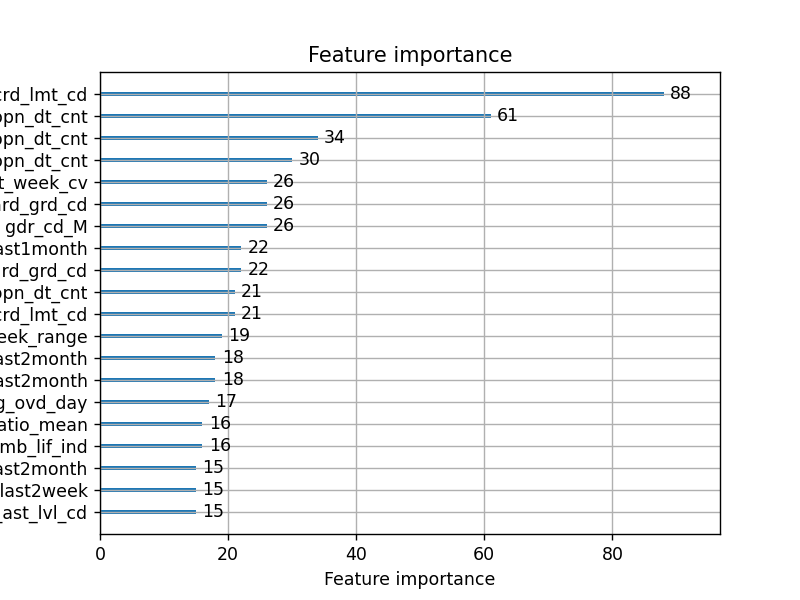

In [2641]:
lgb.plot_importance(gbm, max_num_features = 20)

In [2642]:
feat_importance = gbm.feature_importance()

feat_names = gbm.feature_name()

feat_imp_srs = pd.Series(feat_importance, index = feat_names)

In [2643]:
feat_imp_srs.sort_values().iloc[-50:]

Trx_Cod1_Cd_3_amt_last1month                              9
Trx_Cod2_Cd_213_mean_last2month                           9
job_year                                                  9
Trx_Cod2_Cd_308_sum_last2month                            9
Trx_Cod1_Cd_3_amt_ratio_last2month                        9
Trx_Cod1_Cd_3_amt_month_1_sum_diff_ratio                 10
Trx_Cod1_Cd_3_amt_biweek_cv                              10
Trx_Cod1_Cd_3_mean_last2month                            10
tm_slot_3_ratio_last2month                               10
out_pw_div_l1y_crd_card_csm_amt_dlm_cd_exp_last1month    10
trd_month1_sum_outin_ratio                               10
Trx_Cod1_Cd_1_mean_last1month                            10
acdm_deg_cd_F                                            10
Trx_Cod2_Cd_116_mean_last2month                          10
Trx_Cod2_Cd_134_amt_last2month                           11
Dat_Flg3_Cd_B_mean_tm_slot_3_last2month                  11
hav_car_grp_ind                         